# SMACD Event Based Back Tester and Results 

## Table of Contents
1.2 [Common Class](#Common-Class)<br>
1.3 [SMACD Strategy Class](#SMACD-Strategy-Class)<br>
1.4 [Grid Search on train set (2010-2013) for best parameters](#Grid-search) <br>
    1.4.1 [Grid search results](#Choosing-Best-Parameters-using-Training-and-Validation-Splits) <br>
    1.4.2 [Top 10 parameter combinations based on Calmar Ratio](#Top-10-parameter-combinations)<br>
    1.4.3 [Countplot of the Best Parameters](#Countplot-of-the-occurence-of-each-parameter-in-the-top-10-choices)<br>
    1.4.4 [Final Paramaters](#Final-model-parameters-selection)<br>
5. [Results of final model on train set (2010-2015)](#Final-model-results-on-Training-Set)<br>
6. [Results of final model on test set without fees(2016-2019)](#Final-model-results-on-Test-Set-without-Trading-Fees)<br>
7. [Results of final model on test set with fees(2016-2019)](#Final-model-results-on-Test-Set-with-Trading-Fees)<br>



**Note: If you do not want to run grid search again, please download the files from https://github.com/siddharthgohil/Trading_with_MACDnSMA/tree/main/Tuning**

In [1]:
# Import modules
import math
import pandas as pd
import numpy as np
import pandas_datareader as pdr
import yfinance as yf
import matplotlib.pyplot as plt
import itertools
from tqdm import tqdm
import pickle
import os
from time import time
from dateutil.relativedelta import relativedelta
from datetime import datetime

from ta.utils import dropna
from ta.volatility import AverageTrueRange
from ta.trend import SMAIndicator
from ta.trend import EMAIndicator
from ta.trend import MACD
from ta.momentum import RSIIndicator

## Common Class

In [2]:
class Common_Class():

    def __init__(self, symbol, start, end, interval, capital, transaction_cost, benchmark, verbose, stock_data_dict, benchmark_df,buy_on):        
        #new dicts as now there will be multiple stocks. Each stock will have its own position/quantity etc
        self.symbol = symbol
        self.all_data = stock_data_dict
        self.position = {stock:0 for stock in self.symbol}
        self.quantity = {stock:0 for stock in self.symbol}
        self.start = start
        self.end = end
        self.interval = interval
        self.initial_capital = capital # Initial capital
        self.capital = capital # This capital will change accordingly depending on the trades
        self.transaction_cost = transaction_cost
        self.trades = 0 # Number of trades
        self.verbose = verbose # if you want to see detailed output (logs)
        self.benchmark = benchmark
        self.benchmark_df = benchmark_df
        self.buy_on= buy_on
        self.prepare_data() # prepares the data
        

    def prepare_data(self):
        # Get data for all stocks
        if self.all_data is None:
            stock_data_dict = {}
            for stock in self.symbol:
                hist_stock = pdr.get_data_yahoo(stock, self.start, self.end)
                bt_data = pd.DataFrame()
                bt_data["Close_Price"] = hist_stock["Close"]
                bt_data["Open_Price"] = hist_stock["Open"]
                bt_data["Low_Price"] = hist_stock["Low"]
                bt_data["High_Price"] = hist_stock["High"]
                bt_data["Return"] = np.log(bt_data["Close_Price"] / bt_data["Close_Price"].shift(1))
                bt_data = bt_data.dropna()
                stock_data_dict[stock] = bt_data
            self.all_data = stock_data_dict

        # Get the data for the benchmark
        if self.benchmark_df is None:
            hist_benchmark = pdr.get_data_yahoo(self.benchmark, self.start, self.end)
            bt_data = pd.DataFrame()
            bt_data["Close_Price"] = hist_benchmark["Close"]
            bt_data["Benchmark Returns"] = np.log(bt_data["Close_Price"] / bt_data["Close_Price"].shift(1))
            bt_data = bt_data.dropna()
            self.benchmark_df = bt_data
    
    def close_graph(self, ticker):
        plt.figure(figsize=(15, 5))
        plt.plot(self.all_data[ticker]["Close_Price"] ,color='black', label='Price', linestyle='dashed')
        plt.xlabel("Days")
        plt.ylabel("Price")
        plt.title("Close Prices of {}".format(ticker))
        plt.legend()
        plt.grid()
        plt.show()

    def return_date_price(self, bar, stock, price_type = 'Close'): #now we will also pass the stock as parameter
        # A bar is a unit of data at a given time, depends on the interval you choose, it provides you OHLCV and time info
        # Since we have modeled close prices, we will get the price and date
        i = str(stock)
        date = str(self.all_data[i].index[bar])[:10]  # :10 to only get the date
        if (price_type == "Close"): price = self.all_data[i].Close_Price.iloc[bar]
        elif (price_type == "Open"): price = self.all_data[i].Open_Price.iloc[bar]
        return date, price

    def realised_balance(self, bar):
        #returns the realised capital in your account at a given time period / bar
        date, price = self.return_date_price(bar, self.symbol[0]) # only concerned with date so any stock will do
        print("Date :{} | Realised Balance: {:0.1f}".format(date,self.capital))

    def unrealised_balance(self, bar):
        #returns you the unrealised capital (trades in progress) in your account at a given time period / bar
        ub = 0
        for stock in self.symbol:
            date, price = self.return_date_price(bar, stock)
            ub =  ub + self.quantity['{}'.format(stock)] *price
        #print("Date :{} | Unrealised Balance: {:0.1f}".format(date,ub))

    def total_balance(self, bar):
        #Unrealised plus realised
        ub = 0
        for stock in self.symbol:
            date, price = self.return_date_price(bar, stock)
            ub =  ub + self.quantity['{}'.format(stock)] *price
        tb = ub + self.capital
        #print("Date :{} | Total Balance: {:0.1f}".format(date,tb))
        return tb


    def performance_plots(self):# once we have dataframe of daily account balances
        Final_result_data = self.Final_result_data #saving time to write self everywhere
        interval = str(self.interval)
        f,ax = plt.subplots(2,3,figsize=(20,10))

        #plot 1: Close Price os stock
        plt.subplot(2, 3, 1)
        for stock in self.symbol:
            plt.plot(Final_result_data['Returns_{}'.format(stock)].cumsum(), label='{}'.format(stock), linestyle='dashed')
        plt.title("Cum Log returns of included stocks")
        plt.xlabel(interval)
        plt.legend()
        plt.grid()

        #plot 2: Histogram of Strategy returns
        plt.subplot(2, 3, 2)
        plt.hist(Final_result_data['capital_log_returns'], bins = 35, label='Strategy Returns', linestyle='dashed')
        plt.title("Histogram of Strategy returns")
        plt.xlabel(interval)
        plt.legend()
        plt.grid()

        #plot 3: Strategy vs Instrument
        plt.subplot(2, 3, 3)
        plt.plot(Final_result_data['Total_Stock_Returns_cum_sum'],color='red', label='Equal weighted stock Returns', linestyle='dashed')
        plt.plot(Final_result_data['capital_returns_log_cum_sum'].dropna(), label ='Strategy Returns')
        plt.plot(Final_result_data['Benchmark Returns'].cumsum(), label ='Benchmark Returns')
        plt.title("Strategy Vs Stock Cum Return Curve")
        plt.xlabel(interval)
        plt.legend()
        plt.grid()

        #plot 4: Drawdown
        plt.subplot(2, 3, 4)
        plt.plot(Final_result_data["capital_returns_log_cum_sum"].dropna(), label='Cum log returns')
        plt.plot(Final_result_data["Cum_Max"].dropna(), label =  'Max Drawdown')
        plt.title("Drawdown")
        plt.xlabel(interval)
        plt.legend()
        plt.grid()

        #plot 5: Equity Curve
        plt.subplot(2, 3,  5)
        plt.plot(Final_result_data["capital"].dropna(), label =  'Equity $')
        plt.title("Equity Curve")
        plt.xlabel(interval)
        plt.legend()
        plt.grid()

        plt.suptitle("Performance Plots")
        f.delaxes(ax[1,2]) # to delete the last subplot

        plt.show()

    def performance_metrics(self, log_returns, log_benchmark_returns,tuning= False):
        # Drawdown
        portfolio_gross_cum_returns = log_returns.cumsum()
        portfolio_gross_cum_max_returns = portfolio_gross_cum_returns.cummax()
        drawdown = portfolio_gross_cum_max_returns - portfolio_gross_cum_returns
        max_drawdown = drawdown.max()
             
        zero_periods = drawdown[drawdown == 0] # Getting the max drawdown period
        delta_values = (zero_periods.index[1:] - zero_periods.index[:-1])
        
        benchmark_annual_regular_returns = np.exp(log_benchmark_returns.mean() * 252) -1
        
        # Beta
        df = pd.DataFrame()
        df['capital_log_returns'] = log_returns
        df['Benchmark Returns'] = log_benchmark_returns
        matrix = df[['capital_log_returns', 'Benchmark Returns']].cov()
        beta = matrix.iat[0, 1] / matrix.iat[1, 1]

        # Portfolio information ratio
        portfolio_log_returns = log_returns.sum() * 100
        portfolio_normal_returns = (np.exp(log_returns.sum())-1) * 100
        portfolio_annual_mean_returns = np.exp(log_returns.mean() * 252) - 1
        portfolio_annual_regular_std = (np.exp(log_returns) -1).std() * (252 ** 0.5)
        portfolio_annual_sharpe_ratio = portfolio_annual_mean_returns / portfolio_annual_regular_std
        
        portfolio_benchmark = log_returns- log_benchmark_returns
        average_of_difference = portfolio_benchmark.mean()
        std_of_difference = portfolio_benchmark.std()
        daily_ir = average_of_difference / std_of_difference
        annual_ir = daily_ir * (252 ** 0.5)

        # Treynor ratio
        portfolio_treynor_ratio = portfolio_annual_mean_returns / beta

        # Calmar ratio
        portfolio_calmar_ratio = portfolio_annual_mean_returns / max_drawdown

        # Sortino ratio
        portfolio_negative_returns_df = log_returns[log_returns < 0]
        annual_negative_portfolio_std = (np.exp(portfolio_negative_returns_df) - 1).std() * (252 ** 0.5)
        portfolio_sortino_ratio = portfolio_annual_mean_returns / annual_negative_portfolio_std
        
        metrics_dict = {'portfolio_log_returns':portfolio_log_returns,
                        "portfolio_normal_returns":portfolio_normal_returns,
                        "portfolio_annual_mean_returns":portfolio_annual_mean_returns,
                        "portfolio_annual_regular_std":portfolio_annual_regular_std,
                        "portfolio_annual_sharpe_ratio":portfolio_annual_sharpe_ratio,
                        "benchmark_annual_regular_returns":benchmark_annual_regular_returns,
                        "annual_ir":annual_ir,
                        "portfolio_treynor_ratio":portfolio_treynor_ratio,
                        "portfolio_calmar_ratio":portfolio_calmar_ratio,
                        "portfolio_sortino_ratio":portfolio_sortino_ratio,
                        "max_drawdown":max_drawdown,
                        "max_drawdown_period":delta_values.max()}
        if (tuning== False):
            print("Normal Portfolio returns: {:0.2f} %".format(metrics_dict["portfolio_normal_returns"]))
            print('Log Portfolio returns: {:0.2f} %'.format(metrics_dict["portfolio_log_returns"]))
            print('Portfolio Annual Mean returns: {:0.2f}'.format(metrics_dict["portfolio_annual_mean_returns"]))
            print('Portfolio Annual Regular std: {:0.2f}'.format(metrics_dict["portfolio_annual_regular_std"]))
            print('Portfolio Annual Sharpe Ratio: {:0.2f}'.format(metrics_dict["portfolio_annual_sharpe_ratio"]))
            print('{} Benchmark Annual Mean returns: {:0.2f}'.format(self.benchmark, metrics_dict["benchmark_annual_regular_returns"]))
            print('Annual Information Ratio: {:0.2f}'.format(metrics_dict["annual_ir"]))
            print('Portfolio Treynor Ratio: {:0.2f}'.format(metrics_dict["portfolio_treynor_ratio"]))
            print('Portfolio Calmar Ratio: {:0.2f}'.format(metrics_dict["portfolio_calmar_ratio"]))
            print('Portfolio Sortino Ratio: {:0.2f}'.format(metrics_dict["portfolio_sortino_ratio"]))
            print("The maximum drawdown: {:.2f} %".format(metrics_dict["max_drawdown"]*100))
            print("The maximum drawdown period: {:.2f} days".format(metrics_dict["max_drawdown_period"]))
        return metrics_dict
    
    def performance(self,tuning):
        df = pd.DataFrame() # creating a new datframe to store aggregated values

        df['capital'] = self.total_balance_df
        df['capital_after_settlement'] = df['capital'].shift(-1)
        df['capital_log_returns'] = np.log(df['capital_after_settlement']/df['capital'])
        
        trade_start_date = df['capital'].index[0] # If intraday, then index needs to be adjusted with time, for daily, its fine
        trade_end_date = df['capital'].index[-1] # This will work when interval is 1D
        df.index = range(df.shape[0])
        # Benchmark Returns
        self.benchmark_df.index = pd.to_datetime(self.benchmark_df.index.date)
        self.benchmark_df= self.benchmark_df[trade_start_date:trade_end_date]
        df['Benchmark Returns'] = list(self.benchmark_df['Benchmark Returns'])

        #Also, since we have multiple stocks, we need to calculate expected returns to comapre against the strategy
        for stock in self.symbol:
            df['Returns_{}'.format(stock)] = self.all_data[stock][trade_start_date:trade_end_date]['Return'].tolist()
        c= df.columns
        # Simulating returns for equal weighted stock 
        df['Total_Stock_Returns'] = (df.loc[:,c[-len(self.symbol):]].sum(1))/len(self.symbol) # Sums up last N columns of df and divvide by number of stocks. Equal weightage
        
        df['capital_returns_log_cum_sum'] = df["capital_log_returns"].cumsum()
        df["Cum_Max"] = df["capital_returns_log_cum_sum"].cummax()
        df['Total_Stock_Returns_cum_sum'] = df['Total_Stock_Returns'].cumsum()
        
        self.Final_result_data = df
        if (tuning== False):
            print("=" *50)
            print("Starting capital: {}".format(self.initial_capital))
            print("Final capital: {:0.2f}".format(self.capital))
            print("The total trades taken by the strategy: {}".format(self.trades))
            print(f"Number of Take Profits are {self.tp_count}")
            print(f"Number of Stop Losses are {self.sl_count}")
            print('\n-----------Strategy Stats-----------')
            capital_performance_metrics = self.performance_metrics(df['capital_log_returns'], df['Benchmark Returns'])
            print('\n-----------Equal Weighted Port Stats-----------')
            equal_weighted_port_performance_metrics = self.performance_metrics(df['Total_Stock_Returns'], df['Benchmark Returns'])
            print("=" *50)
        else:
            capital_performance_metrics = self.performance_metrics(df['capital_log_returns'], df['Benchmark Returns'],tuning=True)
        all_res = pd.DataFrame.from_dict([capital_performance_metrics])
        all_res['capital'] = self.capital
        return all_res
            

    def exit_condition(self,entry_price, exit_price, position_type):
        if (position_type == 1):
            if (exit_price>entry_price):
                self.tp_count += 1
                if self.verbose: print("---------Close Long at TP----------")
            else:
                self.sl_count += 1
                if self.verbose: print("---------Close Long at SL----------")
        elif (position_type == -1):
            if (exit_price<entry_price):
                self.tp_count += 1
                if self.verbose: print("---------Close Short at TP----------")
            else:
                self.sl_count += 1
                if self.verbose: print("---------Close Short at SL----------")
    
    
    def buy_order(self,bar,stock,quantity=None, dollar =None ):
        date, price = self.return_date_price(bar,stock,price_type=self.buy_on)
        if quantity == None:
            quantity =  math.floor(dollar/(price* (self.transaction_cost+1)))
        self.capital = self.capital - ((quantity * price)*(1 + self.transaction_cost)) # capital will be lost in buying
        self.quantity['{}'.format(stock)] = self.quantity['{}'.format(stock)] + quantity
        self.trades = self.trades + 1
        self.position['{}'.format(stock)] = 1
        tb = self.total_balance(bar)

        if self.verbose:
            print("Bought {} shares of {} at {:0.1f} per share worth {:0.1f} $".format(quantity,stock, price, quantity * price))
            self.realised_balance(bar)


    def sell_order(self,bar,stock, quantity=None, dollar=None ):
        date, price = self.return_date_price(bar, stock,price_type=self.buy_on)
        if quantity == None:
            quantity = math.floor(dollar/(price* (self.transaction_cost+1)))
        self.capital = self.capital + ((quantity * price)*(1 - self.transaction_cost)) # capital will be added after selling
        self.quantity['{}'.format(stock)] = self.quantity['{}'.format(stock)] - quantity
        self.trades = self.trades + 1
        self.position['{}'.format(stock)] = -1
        tb = self.total_balance(bar) # to store the total balance due to all the stocks at the end of the day, so that I get 1 value at the EOD

        if self.verbose:
            print("Sold {} shares of {} at {:0.1f} per share worth {:0.1f} $".format(quantity,stock, price, quantity * price))
            self.realised_balance(bar)

    def last_trade(self, bar,entry_price):# this needs to be check for all open positions of all stocks

        for stock in self.symbol:
            date, price = self.return_date_price(bar, stock,price_type=self.buy_on)
            last_quantity = self.quantity['{}'.format(stock)]
            self.capital = self.capital + last_quantity * price
            self.quantity['{}'.format(stock)] = 0 # as no more quantity now. all will be settled
            curr_pos = self.position['{}'.format(stock)]
            if (curr_pos == -1): # if closing out a short position
                last_quantity = - last_quantity # to keep a positve nymber in records. Note, self.quantity is always maintianing a +/- sign.
                self.position['{}'.format(stock)] = 1 # to record we are buying to close out
            else:
                last_quantity =  last_quantity # to keep a positve nymber in records
                self.position['{}'.format(stock)] = -1 # to record we are selling to close out
            tb = self.total_balance(bar)
            
            if self.verbose:
                print("Closed open trades for {} shares of {} at {:0.1f} per share worth {:0.1f} $".format(last_quantity,stock, price, last_quantity * price))
            if (last_quantity>0): 
                self.trades = self.trades +1
                self.exit_condition(entry_price, price, curr_pos)

## SMACD Strategy Class

In [3]:
class SMACD_Strategy(Common_Class):
    
    def __init__(self,symbol, benchmark,start, end, interval, capital, transaction_cost, primary_trend_window,buy_on,long_sl_ATR_multiple,risk_reward_long,
                 close_n_sma_distance_long_multiple,long_rsi_limit,short_sl_ATR_multiple,risk_reward_short,
                 close_n_sma_distance_short_multiple,short_rsi_limit,verbose,stock_data_dict,benchmark_df, plot_individual_stocks):
        super().__init__(symbol, start, end, interval, capital, transaction_cost,benchmark,verbose,stock_data_dict,benchmark_df,buy_on)
        self.primary_trend_window = primary_trend_window
        self.long_sl_ATR_multiple = long_sl_ATR_multiple,
        self.risk_reward_long = risk_reward_long,
        self.close_n_sma_distance_long_multiple= close_n_sma_distance_long_multiple,
        self.long_rsi_limit = long_rsi_limit,
        self.short_sl_ATR_multiple = short_sl_ATR_multiple,
        self.risk_reward_short = risk_reward_short,
        self.close_n_sma_distance_short_multiple = close_n_sma_distance_short_multiple,
        self.short_rsi_limit = short_rsi_limit
        self.Final_result_data = pd.DataFrame()
        self.plot_individual_stocks = plot_individual_stocks
        self.sl_count = 0
        self.tp_count = 0

    def close_position(self, ticker, bar):
        # to clear previous long position
        if self.position[ticker] == 1:
            self.sell_order(bar,ticker, quantity = self.quantity[ticker]) 
            
        #to clear previous short position and therefore negative quantity.
        elif self.position[ticker] == -1:
            self.buy_order(bar,ticker, quantity = -self.quantity[ticker]) 
            
        self.position[ticker] = 0
    
    def go_long(self, ticker, bar, quantity = None, dollar = None):
        # to create new fresh order
        if quantity:
            self.buy_order (bar,ticker, quantity = quantity) 
        elif dollar:
            if dollar == 'all':
                dollar = self.capital
                self.buy_order(bar,ticker, dollar = dollar)
        
    def go_short(self, ticker, bar, quantity = None, dollar = None):
        # to create new fresh order
        if quantity:
            self.sell_order(bar,ticker, quantity = quantity) 
        elif dollar:
            if dollar == 'all':
                dollar = self.capital
                self.sell_order(bar,ticker, dollar = dollar)


    def visualise_strategy(self, ticker,  axs):
            axs.plot(self.all_data[ticker]["Close_Price"] ,color='black', label='Price', linestyle='dashed')
            axs.plot(self.all_data[ticker]["SMA"], color='b', label='Short term MA')
            
            # Entry Points
            open_long = self.all_data[ticker]['Open_Entry'] == "Open Long"
            open_short = self.all_data[ticker]['Open_Entry'] == "Open Short"
            
            # Exit points
            close_short_tp = (self.all_data[ticker]['Close_Entry'] == "Close Short at TP")
            close_long_tp = (self.all_data[ticker]['Close_Entry'] == "Close Long at TP")
            close_short_sl = (self.all_data[ticker]['Close_Entry'] == "Close Short at SL")
            close_long_sl = (self.all_data[ticker]['Close_Entry'] == "Close Long at SL")
            
            axs.plot(self.all_data[ticker][open_long].index, self.all_data[ticker][open_long]['Close_Price'], '^',
                 color = 'g', markersize = 12,alpha=0.6, label="Open Long")

            axs.plot(self.all_data[ticker][open_short].index, self.all_data[ticker][open_short]['Close_Price'], 'v',
                     color = 'r', markersize = 12,alpha=0.6, label="Open Short")

            axs.plot(self.all_data[ticker][close_long_tp].index, self.all_data[ticker][close_long_tp]['Close_Price'], '*',
                     color = 'g', markersize = 12,alpha=0.8, label="TP Long")

            axs.plot(self.all_data[ticker][close_short_tp].index, self.all_data[ticker][close_short_tp]['Close_Price'], '*',
                     color = 'r', markersize = 12,alpha=0.8, label="TP Short")

            axs.plot(self.all_data[ticker][close_long_sl].index, self.all_data[ticker][close_long_sl]['Close_Price'], 'x',
                     color = 'g', markersize = 12,alpha=0.8, label="SL Long", mew=4)

            axs.plot(self.all_data[ticker][close_short_sl].index, self.all_data[ticker][close_short_sl]['Close_Price'], 'x',
                     color = 'r', markersize = 12,alpha=0.8, label="SL Short", mew=4)

            axs.set_xlabel("Days")
            axs.set_ylabel("Price")
            axs.set_title("Price of {}".format(ticker))
            axs.legend()
            plt.grid()

    def visualise_position(self, ticker, axs):
            axs.plot(self.all_data[ticker]["Final Position"])
            axs.set_title("Long/Short status for {}".format(ticker))
            axs.grid()

    def visualise_stock_returns_distribution(self, ticker, axs):
            axs.hist(self.all_data[ticker][self.all_data[ticker]["Strategy_Returns"] != 0]["Strategy_Returns"], bins = 40, label='Strategy Returns', alpha=0.5)
            axs.hist(self.all_data[ticker][self.all_data[ticker]["Stock_Returns"] != 0]["Stock_Returns"], bins = 40, label='Stock Returns', alpha=0.5)
            axs.set_title("Histogram of Stock Daily Log Returns for {}".format(ticker))
            axs.legend()
            axs.grid()

    def visualise_stock_and_strategy_returns(self, ticker, axs):
            axs.plot(self.all_data[ticker][["Strategy_Returns"]].cumsum(), label='Strategy_Returns')
            axs.plot(self.all_data[ticker][["Stock_Returns"]].cumsum(), label='Stock_Returns')
            axs.legend()
            axs.set_title('Stock vs Strategy Returns for {}'.format(ticker))
            axs.grid()

    def add_technicals(self, ticker):
        # SMA
        SMA = SMAIndicator(close = self.all_data[ticker]["Close_Price"], window = self.primary_trend_window, fillna= False)
        self.all_data[ticker]["SMA"] = SMA.sma_indicator()
        
        # ATR and SMA of ATR
        ATR = AverageTrueRange(high = self.all_data[ticker]["High_Price"],
                           low = self.all_data[ticker]["Low_Price"],
                           close = self.all_data[ticker]["Close_Price"])
        self.all_data[ticker]['ATR'] = ATR.average_true_range()
        ATR_SMA = SMAIndicator(close = self.all_data[ticker]['ATR'], window = 14, fillna= False)
        self.all_data[ticker]["ATR_SMA"] = ATR_SMA.sma_indicator()
        
        # MACD
        MACD_ = MACD(close = self.all_data[ticker]["Close_Price"]) 
        self.all_data[ticker]['MACD Fast'] = MACD_.macd()
        self.all_data[ticker]['MACD Slow'] = MACD_.macd_signal()
        
        # RSI
        RSI = RSIIndicator(close =  self.all_data[ticker]["Close_Price"])
        self.all_data[ticker]['RSI'] = RSI.rsi()

        # Exit Conditions if invested in that day
        self.all_data[ticker]['Stop Loss Long'] = self.all_data[ticker]["Open_Price"] - self.long_sl_ATR_multiple*self.all_data[ticker]['ATR_SMA'] 
        self.all_data[ticker]['Take Profit Long'] = self.all_data[ticker]["Open_Price"] +self.risk_reward_long*(self.long_sl_ATR_multiple*self.all_data[ticker]['ATR_SMA'])

        self.all_data[ticker]['Stop Loss Short'] = self.all_data[ticker]["Open_Price"] + self.short_sl_ATR_multiple*self.all_data[ticker]['ATR_SMA'] # 1
        self.all_data[ticker]['Take Profit Short'] = self.all_data[ticker]["Open_Price"]-self.risk_reward_short*(self.short_sl_ATR_multiple*self.all_data[ticker]['ATR_SMA'])


        # Signal Logic, combine 3 signals to produce the final signal
        self.all_data[ticker]['signal_1'] = np.where( 
                            (self.all_data[ticker]['Close_Price'] > (self.all_data[ticker]['SMA'] - self.close_n_sma_distance_short_multiple*self.all_data[ticker]['ATR_SMA']) ) & (self.all_data[ticker]['Close_Price'] < self.all_data[ticker]['SMA']),
                            -1.0,   0) # When it is between the close and abit below it, we short

        self.all_data[ticker]['signal_1'] = np.where( 
                            (self.all_data[ticker]['Close_Price'] < (self.all_data[ticker]['SMA'] + self.close_n_sma_distance_long_multiple*self.all_data[ticker]['ATR_SMA']) ) & (self.all_data[ticker]['Close_Price'] > self.all_data[ticker]['SMA']) ,
                            1.0,  self.all_data[ticker]['signal_1']) # When it is between the close and abit above it, we long

        self.all_data[ticker]['signal_2'] = np.where(self.all_data[ticker]['MACD Fast'] >  self.all_data[ticker]['MACD Slow'],1.0,-1.0) 
        self.all_data[ticker]['signal_3'] = np.where(self.all_data[ticker]['ATR_SMA'] >  self.all_data[ticker]['ATR'],1.0,-1.0) # Long in period of low vol and short in period of high vol
        
        # Cleaning the signal and getting its strength
        self.all_data[ticker]['Signal Combined'] = ( self.all_data[ticker]['signal_1']+ self.all_data[ticker]['signal_2'] + self.all_data[ticker]['signal_3'] )/3.0
        self.all_data[ticker]['Signal Clean'] = self.all_data[ticker]['Signal Combined'].map(lambda x : 0 if x not in [-1.0,1.0] else x) # Long only when all 3 signals are 1 and short only when all 3 signals are -11
        self.all_data[ticker]['Strength of Signal'] = ((abs(self.all_data[ticker]['MACD Fast'] -  self.all_data[ticker]['MACD Slow']))) * self.all_data[ticker]['Signal Clean']
        self.strengths_df[ticker] = self.all_data[ticker]['Strength of Signal']
        
        self.all_data[ticker]['Final Position'] = 0
        self.all_data[ticker][ "Open_Entry"] = ""
        self.all_data[ticker][ "Close_Entry"] = ""

                
    def run_strategy(self,tuning = False):
            self.strengths_df = pd.DataFrame(columns=self.symbol)
            
            for ticker in self.all_data.keys():
                # Get indicators for all the tickers
                self.add_technicals(ticker)
            
            # Stock with the strongest Signal
            self.strengths_df['Chosen'] = self.strengths_df.abs().idxmax(axis=1)
            self.strengths_df['Chosen'] = np.where (self.strengths_df[self.symbol].abs().max(axis = 1) == 0.0, "", self.strengths_df['Chosen'])
            self.strengths_df['Chosen']= self.strengths_df['Chosen'].fillna("")
            latest_action,stock_bought,entry_price = 0,"",0
            self.total_balance_df = pd.DataFrame()
            
            for bar in range(len(self.all_data[self.symbol[0]])):
                date, _ = self.return_date_price(bar, self.symbol[0])
                
                #Daily Balance does not change until we surpass the primary trend window
                if bar <self.primary_trend_window:
                    self.total_balance_df.loc[date, "Daily Balance"] = self.initial_capital
                    continue
                
                #If we are already in a position
                if (stock_bought):
                    # We close at open as we want to get out of our position as soon as possible
                    curr_open_price = self.all_data[stock_bought]["Open_Price"].iloc[bar]
                    
                    # if we are already in a long 
                    if (self.position[stock_bought] == 1): 
                        # Close Long if it hits TP
                        if (curr_open_price  >=  curr_TP ) | (self.all_data[stock_bought]["RSI"].iloc[bar]>self.long_rsi_limit): 
                            self.close_position(stock_bought, bar) 
                            self.all_data[stock_bought].loc[date, "Close_Entry"] = "Close Long at TP"
                            self.position[stock_bought],curr_stop, curr_TP,latest_action,stock_bought = 0,0,0,0,""
                            self.exit_condition(entry_price,curr_open_price,1)

                        # Close Long if it hits SL
                        elif (curr_open_price <= curr_stop ): 
                            self.close_position(stock_bought, bar)
                            self.all_data[stock_bought].loc[date, "Close_Entry"] = "Close Long at SL"
                            self.position[stock_bought],curr_stop, curr_TP,latest_action,stock_bought = 0,0,0,0,""
                            self.exit_condition(entry_price,curr_open_price,1)

                    # if we are already in a short
                    elif (self.position[stock_bought] == -1):
                        # Close Short if it hits SL
                        if (curr_open_price  >= curr_stop ) | (self.all_data[stock_bought]["RSI"].iloc[bar]<self.short_rsi_limit): 
                            self.close_position(stock_bought, bar) 
                            self.all_data[stock_bought].loc[date, "Close_Entry"] = "Close Short at SL"
                            self.position[stock_bought],curr_stop, curr_TP,latest_action,stock_bought = 0,0,0,0,""
                            self.exit_condition(entry_price,curr_open_price,-1)

                        # Close SHort if it hits TP
                        elif (curr_open_price  <= curr_TP ): 
                            self.close_position(stock_bought, bar) 
                            self.all_data[stock_bought].loc[date, "Close_Entry"] = "Close Short at TP"
                            self.position[stock_bought],curr_stop, curr_TP,latest_action,stock_bought = 0,0,0,0,""
                            self.exit_condition(entry_price,curr_open_price,-1)
                
                # if we are not in any position we open a position for the chosen stock at Closing Price
                prev_bar = bar-1
                chosen_stock = self.strengths_df["Chosen"].iloc[bar]
                if (latest_action == 0) & (chosen_stock != ""): 
                    price_bar = self.all_data[chosen_stock][f"{self.buy_on}_Price"].iloc[bar]
                    # If Signal was a long and we have not reached our RSI Long limit
                    if (self.all_data[chosen_stock]["Signal Clean"].iloc[prev_bar] == 1) & (self.all_data[chosen_stock]["RSI"].iloc[prev_bar]<self.long_rsi_limit):
                        if self.verbose: print("\n---------Open Long----------")
                        curr_stop, curr_TP = self.all_data[chosen_stock]["Stop Loss Long"].iloc[prev_bar],self.all_data[chosen_stock]["Take Profit Long"].iloc[prev_bar]
                        self.go_long(chosen_stock, bar, dollar="all") # Go with all money today
                        self.position[chosen_stock] = 1
                        self.all_data[chosen_stock].loc[date, "Open_Entry"] = "Open Long"
                        latest_action,stock_bought,entry_price = 1,chosen_stock,price_bar
                        
                    # If Signal was a Short and we have not reached our RSI Short limit
                    elif (self.all_data[chosen_stock]["Signal Clean"].iloc[prev_bar] == -1) & (self.all_data[chosen_stock]["RSI"].iloc[prev_bar]>self.short_rsi_limit):
                        if self.verbose: print("\n---------Open Short----------")
                        curr_stop, curr_TP = self.all_data[chosen_stock]["Stop Loss Short"].iloc[prev_bar],self.all_data[chosen_stock]["Take Profit Short"].iloc[prev_bar]
                        self.go_short(chosen_stock, bar, dollar ="all") # Go with all money today
                        self.position[chosen_stock] = -1
                        self.all_data[chosen_stock].loc[date, "Open_Entry"] = "Open Short"
                        latest_action,stock_bought,entry_price = -1,chosen_stock,price_bar
                
                if (latest_action!=0) & (stock_bought!= ""): 
                    self.all_data[stock_bought].loc[date,'Final Position'] = latest_action
                
                self.total_balance_df.loc[date, "Daily Balance"] = self.total_balance(bar)

            # Last trade
            self.last_trade(bar,entry_price)
            
            returns_df = self.performance(tuning)
            
            if tuning == False: 
                print("---------- Portfolio statistics ----------")
                # Visualise portfolio performance
                self.performance_plots()

                # Visualisation strategy for each ticker
                if self.plot_individual_stocks:
                    for ticker in self.all_data.keys():
                        # Add position and signal column to the data
                        self.all_data[ticker]['Signal'] = self.all_data[ticker]['Final Position'].diff()
                        # Add stock returns
                        self.all_data[ticker]['Stock_Returns'] = np.log(self.all_data[ticker]["Close_Price"] / self.all_data[ticker]["Close_Price"].shift(1))
                        # Add strategy returns
                        self.all_data[ticker]["Strategy_Returns"] = list(self.Final_result_data['capital_log_returns'])

                        # Visualisations
                        fig, ax = plt.subplots(2, 2, figsize=(15, 8))
                        self.visualise_strategy(ticker, axs=ax[0][0])
                        self.visualise_position(ticker, axs=ax[0][1])
                        self.visualise_stock_and_strategy_returns(ticker, axs=ax[1][0])
                        self.visualise_stock_returns_distribution(ticker, axs=ax[1][1])
                        fig.tight_layout()
                        plt.show()
            return returns_df


In [4]:
def create_data_dict(tickers, benchmark, start,end):
    stock_data_dict = {}
    for stock in tickers:
        hist_stock = pdr.get_data_yahoo(stock, start,end)
        bt_data = pd.DataFrame()
        bt_data["Close_Price"] = hist_stock["Close"]
        bt_data["Open_Price"] = hist_stock["Open"]
        bt_data["Low_Price"] = hist_stock["Low"]
        bt_data["High_Price"] = hist_stock["High"]
        bt_data["Return"] = np.log(bt_data["Close_Price"] / bt_data["Close_Price"].shift(1))
        bt_data = bt_data.dropna()
        stock_data_dict[stock] = bt_data

        # Get the data for the benchmark
    hist_benchmark = pdr.get_data_yahoo(benchmark, start,end)
    bt_data = pd.DataFrame()
    bt_data["Close_Price"] = hist_benchmark["Close"]
    bt_data["Benchmark Returns"] = np.log(bt_data["Close_Price"] / bt_data["Close_Price"].shift(1))
    bt_data = bt_data.dropna()
    benchmark_df = bt_data
    return stock_data_dict, benchmark_df

In [5]:
train_history = {}
# Grid search parameters
primary_trend_window_params =                [50,100]
long_sl_ATR_multiple_params =                [1.5, 2]       # Used for long SL
risk_reward_long_params =                    [2, 3]         # Used for long TP
close_n_sma_distance_long_multiple_params =  [2.5, 3]       # Used to determine how close to SMA can be bought
long_rsi_limit_params =                      [70,80]

# Short Params
short_sl_ATR_multiple_params =                [1, 1.5]      # Used for Short SL
risk_reward_short_params =                    [1, 1.5, 2]   # Used for Short TP
close_n_sma_distance_short_multiple_params = [0.5, 1]       # Used to determine how close to SMA can be bought
short_rsi_limit_params =                     [20, 30]
buy_on =                                     ["Open", "Close"]

all_params_list = [primary_trend_window_params,long_sl_ATR_multiple_params,risk_reward_long_params,
            close_n_sma_distance_long_multiple_params,long_rsi_limit_params,short_sl_ATR_multiple_params,
           risk_reward_short_params,close_n_sma_distance_short_multiple_params,short_rsi_limit_params,buy_on]

parameters = list(itertools.product(*all_params_list))
print(f"{len(parameters)} Available combinations" )

1536 Available combinations


In [6]:
cwd = os.getcwd() 
path = os.path.join(cwd +"\\Tuning" )
if not os.path.exists('Tuning'): os.mkdir('Tuning')
    
def save_file(path, data):
    output = open(path, 'wb')
    pickle.dump(data, output)
    output.close()

def load_file(path):
    pkl_file = open(path, 'rb')
    data = pickle.load(pkl_file)
    pkl_file.close()
    return data

## Grid search
Training set (2010-01-01 to 2013-12-31)

In [7]:
# Change to False if you want to run grid search again. 
# The .pkl files can be found from https://github.com/siddharthgohil/Trading_with_MACDnSMA/tree/main/Tuning
if True:
    all_returns_df = load_file('Tuning/All_Returns.pkl')
    train_history = load_file('Tuning/train_history.pkl')
    print('\nSearch history is loaded from pkl files\n')
else:
    print('This will rerun the grid search!!!\n'*10)
    all_metrics_df, all_returns_df, train_history = pd.DataFrame, pd.DataFrame,{}


Search history is loaded from pkl files



In [8]:
def train_model_with_params(primary_trend_window,long_sl_ATR_multiple,risk_reward_long,close_n_sma_distance_long_multiple,long_rsi_limit,short_sl_ATR_multiple,risk_reward_short,close_n_sma_distance_short_multiple,short_rsi_limit,buy_on,start, end,stock_data_dict,benchmark_df):
    smacd_tuning = SMACD_Strategy( 
                                    symbol = tickers,
                                    benchmark = benchmark_stock_symbol,
                                    start = start,
                                    end = end,
                                    interval = "1d",
                                    capital = 500000,
                                    transaction_cost = 0.01,
                                    primary_trend_window = primary_trend_window,
                                    buy_on = buy_on,
                                    long_sl_ATR_multiple = long_sl_ATR_multiple,
                                    risk_reward_long = risk_reward_long,
                                    close_n_sma_distance_long_multiple =close_n_sma_distance_long_multiple ,
                                    long_rsi_limit= long_rsi_limit,
                                    short_sl_ATR_multiple=short_sl_ATR_multiple,
                                    risk_reward_short=risk_reward_short,
                                    close_n_sma_distance_short_multiple=close_n_sma_distance_short_multiple,
                                    short_rsi_limit=short_rsi_limit,
                                    verbose=False,
                                    stock_data_dict = stock_data_dict,
                                    benchmark_df = benchmark_df, 
                                    plot_individual_stocks=False)
    returns_df= smacd_tuning.run_strategy(tuning = True)
    returns_df["Param"] = f"Combination of param {iteration}"
    returns_df.set_index("Param", inplace=True)
    return returns_df

In [9]:
# We will create the dataframe beforehand to reduce the duration for grid search
tickers = ["F", "JPM", "DHI", "EL", "RYAAY", "NVDA", "MAR"]
benchmark_stock_symbol = "^GSPC"
stock_data_dict, benchmark_df = create_data_dict(tickers, benchmark_stock_symbol, "2010-01-01", "2013-12-31") # We will get the stocks data in advance to reduce the time for grid search
stock_data_dict_val, benchmark_df_val = create_data_dict(tickers, benchmark_stock_symbol, "2014-01-01", "2015-12-31") # We will get the stocks data in advance to reduce the time for grid search
# Grid search
for iteration in tqdm(range(len(parameters))):
    if parameters[iteration] not in train_history:
        # Train Set
        returns_df = train_model_with_params(*parameters[iteration],"2010-01-01", "2013-12-31",stock_data_dict,benchmark_df)
        
        # Validation Set
        returns_df_val = train_model_with_params(*parameters[iteration],"2014-01-01", "2015-12-31",stock_data_dict_val,benchmark_df_val)
        returns_df_val = returns_df_val.add_suffix('_validation')
        returns_df = pd.concat([returns_df, returns_df_val], axis=1)
        if iteration== 0:
            all_returns_df = returns_df
        else:
            all_returns_df.loc[f"Combination of param {iteration}"] = returns_df.loc[f"Combination of param {iteration}"]
        train_history[parameters[iteration]] = True

save_file('Tuning/All_Returns.pkl',all_returns_df)
save_file('Tuning/train_history.pkl',train_history)

100%|██████████| 1536/1536 [00:00<00:00, 1533916.89it/s]


### Choosing Best Parameters using Training and Validation Splits

In [10]:
all_returns_df.columns

Index(['portfolio_log_returns', 'portfolio_normal_returns',
       'portfolio_annual_mean_returns', 'portfolio_annual_regular_std',
       'portfolio_annual_sharpe_ratio', 'benchmark_annual_regular_returns',
       'annual_ir', 'portfolio_treynor_ratio', 'portfolio_calmar_ratio',
       'portfolio_sortino_ratio', 'max_drawdown', 'max_drawdown_period',
       'capital', 'portfolio_log_returns_validation',
       'portfolio_normal_returns_validation',
       'portfolio_annual_mean_returns_validation',
       'portfolio_annual_regular_std_validation',
       'portfolio_annual_sharpe_ratio_validation',
       'benchmark_annual_regular_returns_validation', 'annual_ir_validation',
       'portfolio_treynor_ratio_validation',
       'portfolio_calmar_ratio_validation',
       'portfolio_sortino_ratio_validation', 'max_drawdown_validation',
       'max_drawdown_period_validation', 'capital_validation'],
      dtype='object')

In [11]:
metric = "portfolio_calmar_ratio"
mertic_sorting_direction  = True # True means higher is better, False is lower is better

Since our strategy does not track an index or aim to beat a specific index, We do not use IR or Treynor to judge the best parameters.

Instead to minimise downside risk, we are choosing Calmar Ratio such that we get a strategy with good returns with low drawdowns

In [12]:
all_returns_df['Params'] = parameters
metric_only_df = all_returns_df.copy()

metric_only_df = metric_only_df.sort_values([f'{metric}',f'{metric}_validation'], ascending =[mertic_sorting_direction, mertic_sorting_direction])

# Average out the returns
metric_only_df[f'{metric}_SMA'] = metric_only_df[f'{metric}'].rolling(24).mean()
metric_only_df[f'{metric}_validation_SMA'] = metric_only_df[f'{metric}_validation'].rolling(24).mean()

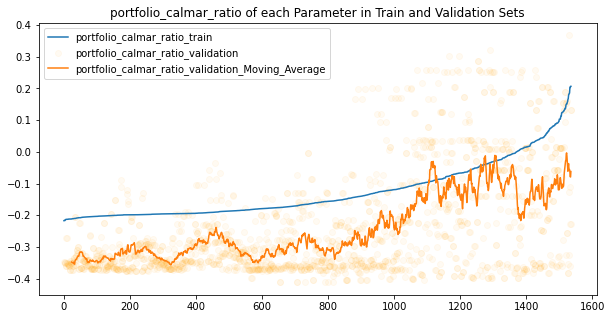

In [13]:
plt.figure(figsize=(10,5))
plt.plot(list(metric_only_df[f'{metric}']), label = f'{metric}_train')
plt.scatter(x = range(1,metric_only_df.shape[0]+1),y = list(metric_only_df[f'{metric}_validation']), label = f'{metric}_validation', alpha=0.05, c = 'orange')
plt.plot(list(metric_only_df[f'{metric}_validation_SMA']), label = f'{metric}_validation_Moving_Average')
plt.title(f'{metric} of each Parameter in Train and Validation Sets')
plt.legend()
plt.show()

Seems like there is still more room to train as validation is still going up as training goes up, but due to time exponential nature of adding an additional param in grid search, we decided not to train further 

#### Top 10 parameter combinations

Parameters with the best returns for both train and validation

In [14]:
# Min Max normalisation so that we can compare
min_params = metric_only_df[[f'{metric}',f'{metric}_validation']].min()
max_params = metric_only_df[[f'{metric}',f'{metric}_validation']].max()
metric_only_df[[f'{metric}_normalised',f'{metric}_validation_normalised']] = (metric_only_df[[f'{metric}',f'{metric}_validation']] - min_params) / (max_params- min_params)

metric_only_df[f'total_{metric}_normalised'] = metric_only_df[f'{metric}_normalised']  +  metric_only_df[f'{metric}_validation_normalised']
metric_only_df['Prev Index'] =  range(1,metric_only_df.shape[0]+1)
top_ten_params = metric_only_df.sort_values([f'total_{metric}_normalised'], ascending =[not mertic_sorting_direction]).head(10)

In [15]:
top_ten_params[[f'total_{metric}_normalised',f'{metric}',f'{metric}_validation',f'{metric}_normalised',f'{metric}_validation_normalised','Params','Prev Index']]

,total_portfolio_calmar_ratio_normalised,portfolio_calmar_ratio,portfolio_calmar_ratio_validation,portfolio_calmar_ratio_normalised,portfolio_calmar_ratio_validation_normalised,Params,Prev Index
Param,,,,,,,
Combination of param 664,1.908040,0.167585,0.367304,0.908040,1.000000,"(50, 2, 3, 2.5, 80, 1.5, 2, 0.5, 20, Open)",1528
Combination of param 762,1.697888,0.206550,0.131865,1.000000,0.697888,"(50, 2, 3, 3, 80, 1.5, 2, 0.5, 30, Open)",1536
Combination of param 760,1.697888,0.206550,0.131865,1.000000,0.697888,"(50, 2, 3, 3, 80, 1.5, 2, 0.5, 20, Open)",1535
Combination of param 666,1.599431,0.149983,0.159176,0.866497,0.732934,"(50, 2, 3, 2.5, 80, 1.5, 2, 0.5, 30, Open)",1522
Combination of param 761,1.598356,0.134293,0.187195,0.829468,0.768888,"(50, 2, 3, 3, 80, 1.5, 2, 0.5, 20, Close)",1517
Combination of param 763,1.598356,0.134293,0.187195,0.829468,0.768888,"(50, 2, 3, 3, 80, 1.5, 2, 0.5, 30, Close)",1518
Combination of param 736,1.562320,0.137800,0.152661,0.837746,0.724574,"(50, 2, 3, 3, 80, 1, 2, 0.5, 20, Open)",1519
Combination of param 738,1.562320,0.137800,0.152661,0.837746,0.724574,"(50, 2, 3, 3, 80, 1, 2, 0.5, 30, Open)",1520
Combination of param 722,1.530139,0.124165,0.152661,0.805566,0.724574,"(50, 2, 3, 3, 80, 1, 1, 0.5, 30, Open)",1511


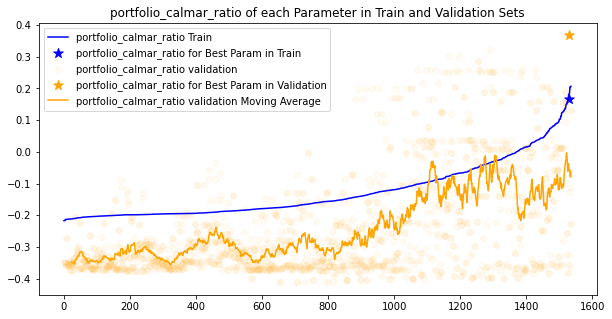

In [16]:
plt.figure(figsize=(10,5))
# Train
plt.plot(list(metric_only_df[f'{metric}']), label = f'{metric} Train', c = 'blue')
plt.scatter(x = top_ten_params.iloc[0]['Prev Index'],y = top_ten_params.iloc[0][f'{metric}'], label = f'{metric} for Best Param in Train', marker='*',s = 100, c = 'blue')
# Validation
plt.scatter(x = range(1,metric_only_df.shape[0]+1),y = list(metric_only_df[f'{metric}_validation']), label = f'{metric} validation', alpha=0.05, c = 'orange')
plt.scatter(x = top_ten_params.iloc[0]['Prev Index'],y = top_ten_params.iloc[0][f'{metric}_validation'], label = f'{metric} for Best Param in Validation', marker='*',s = 100, c = 'orange')
plt.plot(list(metric_only_df[f'{metric}_validation_SMA']), label = f'{metric} validation Moving Average',c = 'orange')

plt.title(f'{metric} of each Parameter in Train and Validation Sets')
plt.legend()
plt.show()

Seems like param 664 is a good candidate

#### Countplot of the occurence of each parameter in the top 10 choices

In [17]:
all_params_name_list = ["primary_trend_window_params","long_sl_ATR_multiple_params","risk_reward_long_params",
            "close_n_sma_distance_long_multiple_params","long_rsi_limit_params","short_sl_ATR_multiple_params",
           "risk_reward_short_params","close_n_sma_distance_short_multiple_params","short_rsi_limit_params","buy_on"]

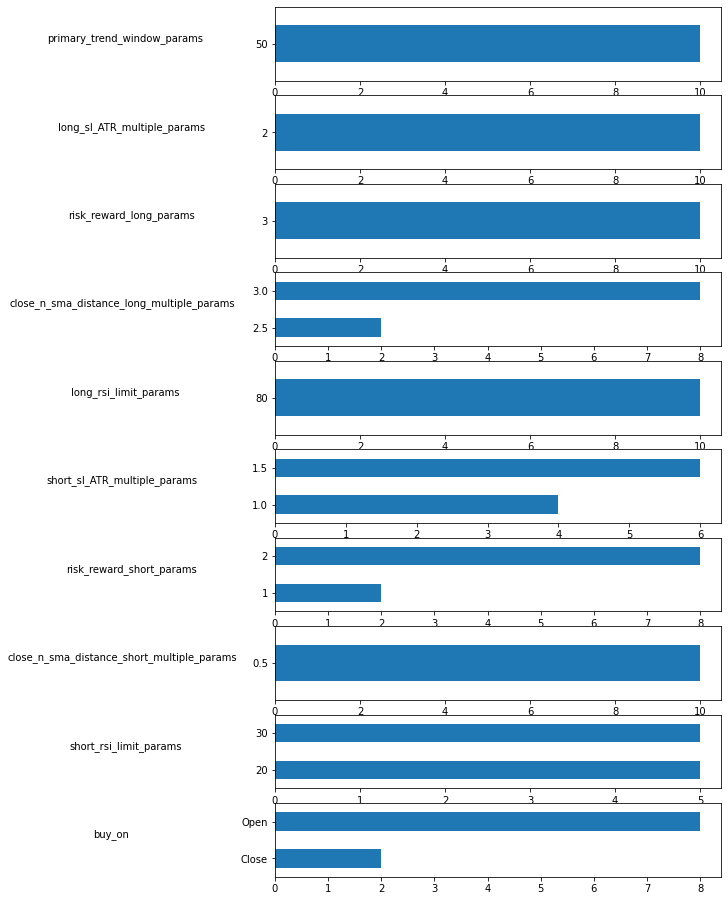

In [18]:
top_ten_params[all_params_name_list] = pd.DataFrame(top_ten_params.Params.tolist(), index= top_ten_params.index)
_,_ = plt.subplots(10,1,figsize=(8,16))
for i in range(1,len(all_params_name_list)+1):
    plt.subplot(10,1, i)
    plt.ylabel("y", rotation=0,labelpad=130)
    top_ten_params.groupby(all_params_name_list[i-1]).count()[metric].plot.barh()

Some parameters occur more frequently in the top 10 params, indicating that there might be a possible correlation of with better returns

#### Final model parameters selection

In [19]:
best_params = top_ten_params.iloc[0]['Params']
for i in range(len(best_params)):
    print(f'{all_params_name_list[i]} = {best_params[i]}')

primary_trend_window_params = 50
long_sl_ATR_multiple_params = 2
risk_reward_long_params = 3
close_n_sma_distance_long_multiple_params = 2.5
long_rsi_limit_params = 80
short_sl_ATR_multiple_params = 1.5
risk_reward_short_params = 2
close_n_sma_distance_short_multiple_params = 0.5
short_rsi_limit_params = 20
buy_on = Open


## Final model results on Training Set

Starting capital: 500000
Final capital: 1486878.48
The total trades taken by the strategy: 74
Number of Take Profits are 18
Number of Stop Losses are 19

-----------Strategy Stats-----------
Normal Portfolio returns: 195.50 %
Log Portfolio returns: 108.35 %
Portfolio Annual Mean returns: 0.20
Portfolio Annual Regular std: 0.25
Portfolio Annual Sharpe Ratio: 0.81
^GSPC Benchmark Annual Mean returns: 0.11
Annual Information Ratio: 0.27
Portfolio Treynor Ratio: -31.29
Portfolio Calmar Ratio: 0.40
Portfolio Sortino Ratio: 1.23
The maximum drawdown: 49.72 %
The maximum drawdown period: 409.00 days

-----------Equal Weighted Port Stats-----------
Normal Portfolio returns: 130.62 %
Log Portfolio returns: 83.56 %
Portfolio Annual Mean returns: 0.15
Portfolio Annual Regular std: 0.21
Portfolio Annual Sharpe Ratio: 0.70
^GSPC Benchmark Annual Mean returns: 0.11
Annual Information Ratio: 0.38
Portfolio Treynor Ratio: 0.12
Portfolio Calmar Ratio: 0.35
Portfolio Sortino Ratio: 0.97
The maximum draw

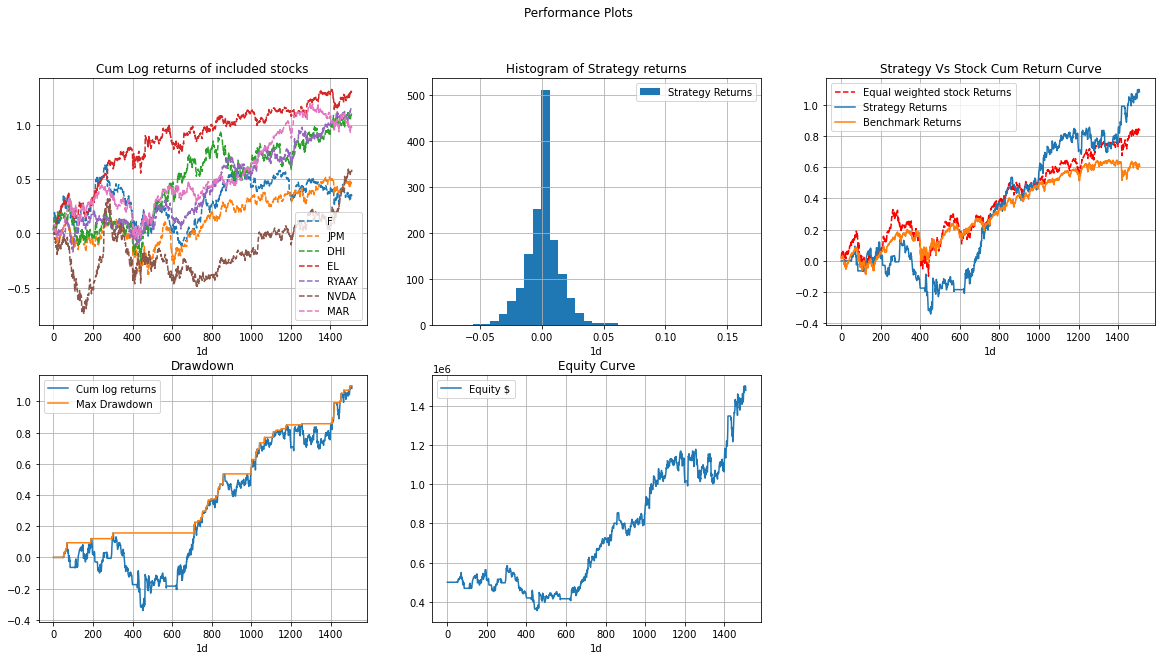

In [20]:
final_model_train_set = SMACD_Strategy(
                # Portfolio configurations
                symbol =  ["F", "JPM", "DHI", "EL", "RYAAY", "NVDA", "MAR"],
                benchmark = "^GSPC",
                start = "2010-01-01",
                end = "2015-12-31",
                interval = "1d",
                capital = 500000,
                transaction_cost = 0.0050,
                # Strategy parameters
                buy_on = best_params[9],
                primary_trend_window = best_params[0],
                # Long Parameters
                long_sl_ATR_multiple = best_params[1],
                risk_reward_long = best_params[2],
                close_n_sma_distance_long_multiple = best_params[3],
                long_rsi_limit= best_params[4],
                # Short Parameters
                short_sl_ATR_multiple = best_params[5],
                risk_reward_short = best_params[6],
                close_n_sma_distance_short_multiple= best_params[7],
                short_rsi_limit = best_params[8],
                # Class configurations
                verbose = False,
                stock_data_dict = None,
                benchmark_df = None,
                plot_individual_stocks=False
                )

final_train_set_results = final_model_train_set.run_strategy()

## Final model results on Test Set without Trading Fees

Starting capital: 500000
Final capital: 1568934.13
The total trades taken by the strategy: 44
Number of Take Profits are 14
Number of Stop Losses are 8

-----------Strategy Stats-----------
Normal Portfolio returns: 215.07 %
Log Portfolio returns: 114.76 %
Portfolio Annual Mean returns: 0.33
Portfolio Annual Regular std: 0.24
Portfolio Annual Sharpe Ratio: 1.40
^GSPC Benchmark Annual Mean returns: 0.12
Annual Information Ratio: 0.65
Portfolio Treynor Ratio: -76.97
Portfolio Calmar Ratio: 1.73
Portfolio Sortino Ratio: 1.88
The maximum drawdown: 19.29 %
The maximum drawdown period: 180.00 days

-----------Equal Weighted Port Stats-----------
Normal Portfolio returns: 89.56 %
Log Portfolio returns: 63.95 %
Portfolio Annual Mean returns: 0.17
Portfolio Annual Regular std: 0.17
Portfolio Annual Sharpe Ratio: 1.01
^GSPC Benchmark Annual Mean returns: 0.12
Annual Information Ratio: 0.47
Portfolio Treynor Ratio: 0.16
Portfolio Calmar Ratio: 0.43
Portfolio Sortino Ratio: 1.33
The maximum drawdo

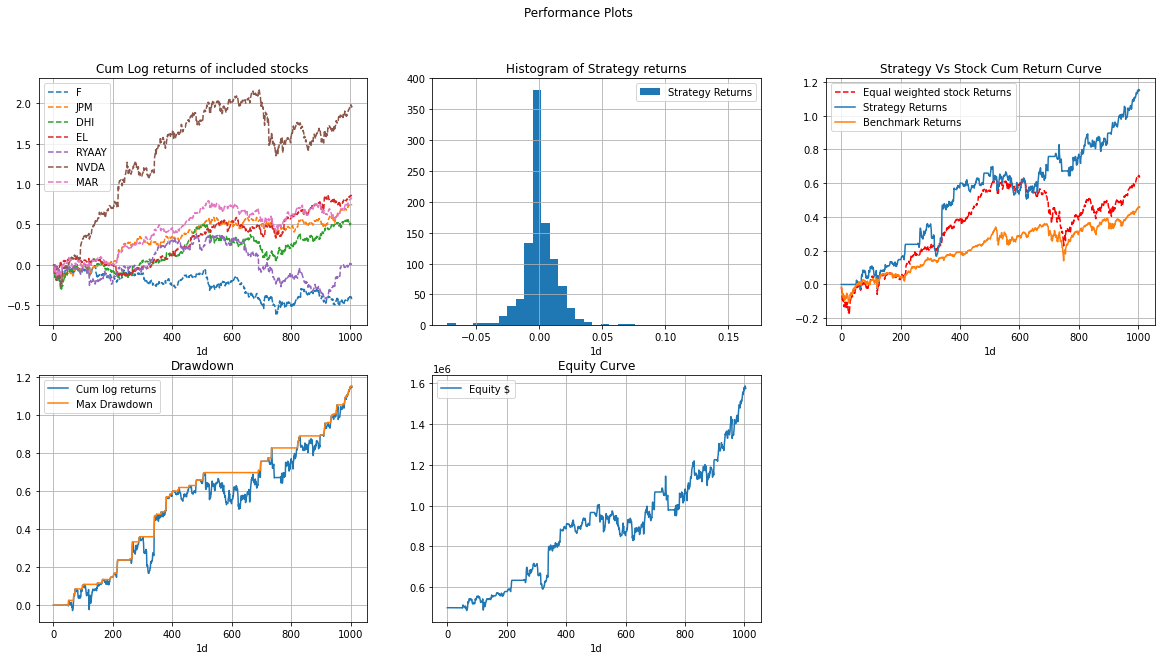

In [21]:
final_model_test_set = SMACD_Strategy(
                # Portfolio configurations
                symbol = ["F", "JPM", "DHI", "EL", "RYAAY", "NVDA", "MAR"],
                benchmark = "^GSPC",
                start = "2016-01-01",
                end = "2019-12-31",
                interval = "1d",
                capital = 500000,
                transaction_cost = 0.00,
                # Strategy parameters
                buy_on = best_params[9],
                primary_trend_window = best_params[0],
                # Long Parameters
                long_sl_ATR_multiple = best_params[1],
                risk_reward_long = best_params[2],
                close_n_sma_distance_long_multiple = best_params[3],
                long_rsi_limit= best_params[4],
                # Short Parameters
                short_sl_ATR_multiple = best_params[5],
                risk_reward_short = best_params[6],
                close_n_sma_distance_short_multiple= best_params[7],
                short_rsi_limit = best_params[8],
                # Class configurations
                verbose = False,
                stock_data_dict = None,
                benchmark_df = None,
                plot_individual_stocks=False
                )
final_model_test_set_results = final_model_test_set.run_strategy()

## Final model results on Test Set With Trading Fees


---------Open Long----------
Bought 8435 shares of JPM at 59.0 per share worth 497496.3 $
Date :2016-03-16 | Realised Balance: 16.2
Sold 8435 shares of JPM at 68.3 per share worth 576447.9 $
Date :2016-10-10 | Realised Balance: 573581.9
---------Close Long at TP----------

---------Open Long----------
Bought 8416 shares of JPM at 67.8 per share worth 570688.9 $
Date :2016-10-21 | Realised Balance: 39.5
Sold 8416 shares of JPM at 74.2 per share worth 624635.5 $
Date :2016-11-10 | Realised Balance: 621551.8
---------Close Long at TP----------

---------Open Long----------
Bought 21692 shares of DHI at 28.5 per share worth 618438.9 $
Date :2017-01-12 | Realised Balance: 20.7
Sold 21692 shares of DHI at 32.2 per share worth 699133.2 $
Date :2017-03-01 | Realised Balance: 695658.2
---------Close Long at TP----------

---------Open Long----------
Bought 54418 shares of F at 12.7 per share worth 692197.0 $
Date :2017-03-02 | Realised Balance: 0.2
Sold 54418 shares of F at 11.7 per share wort

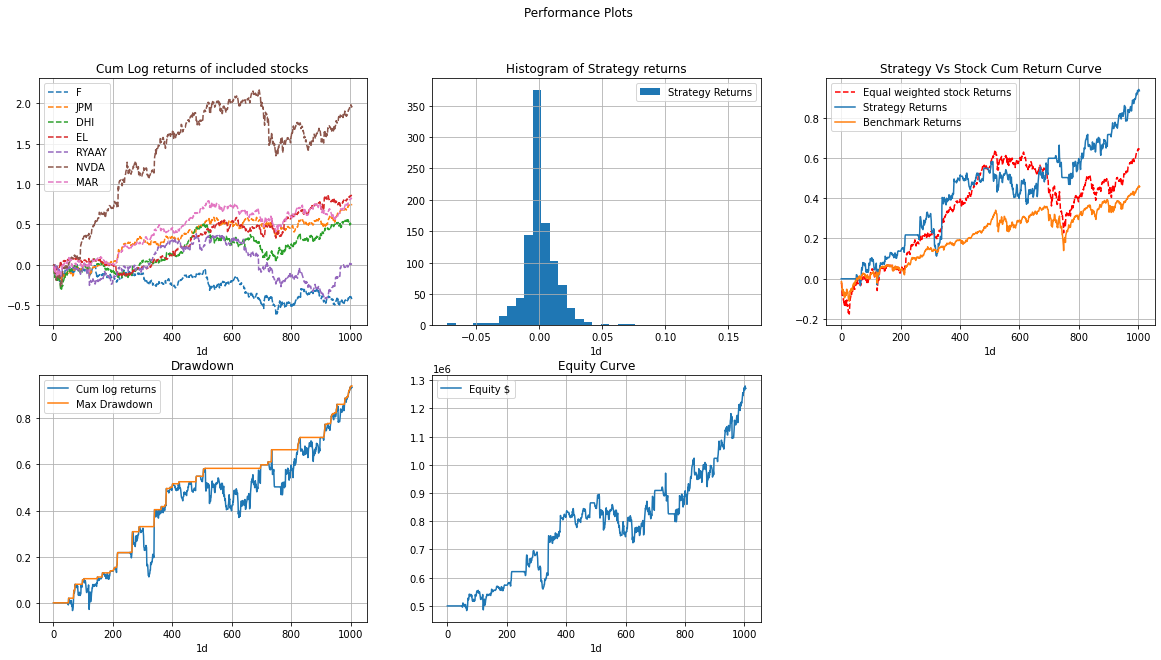

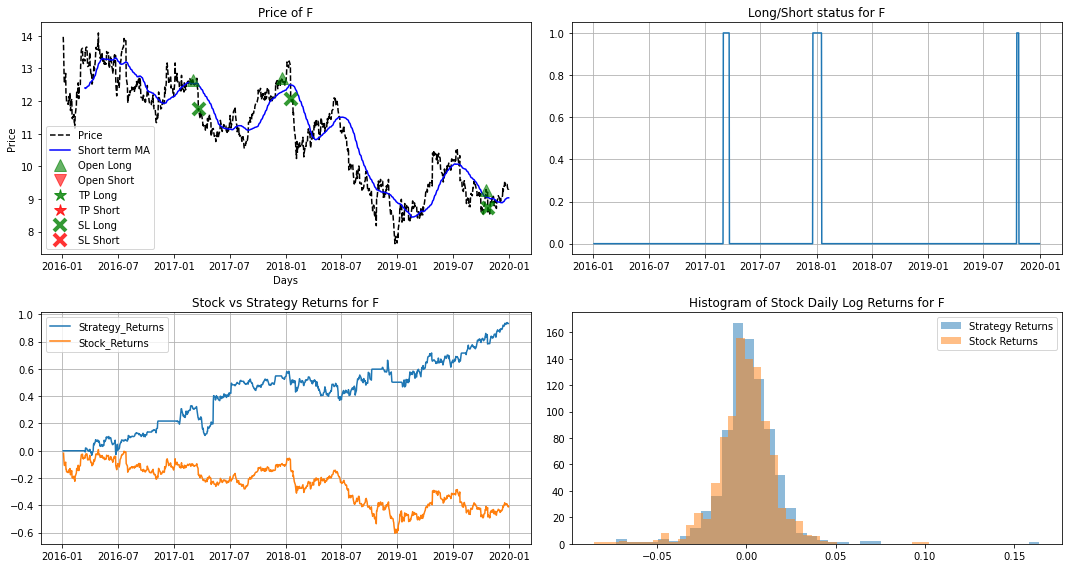

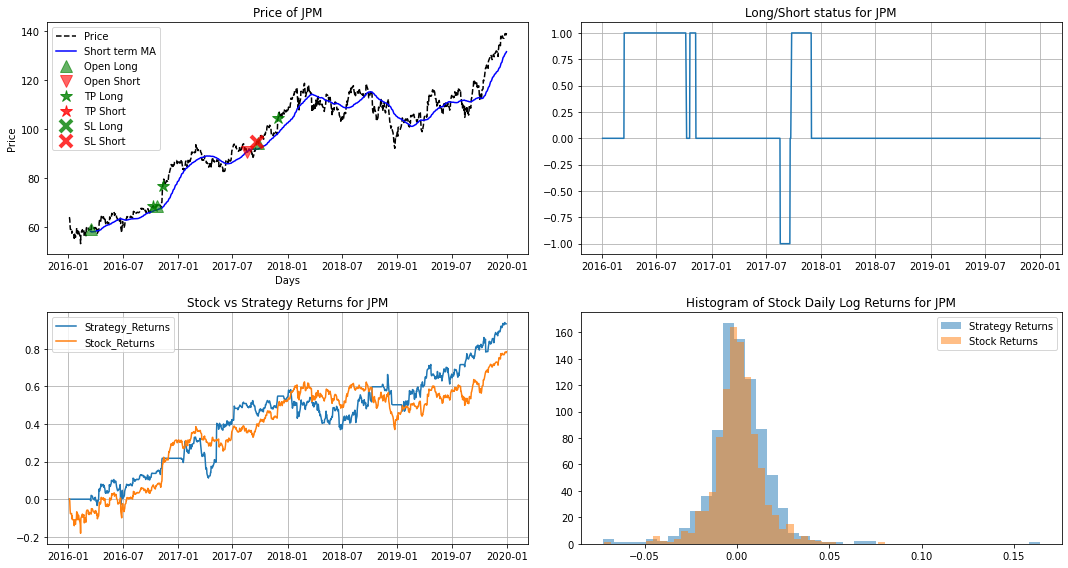

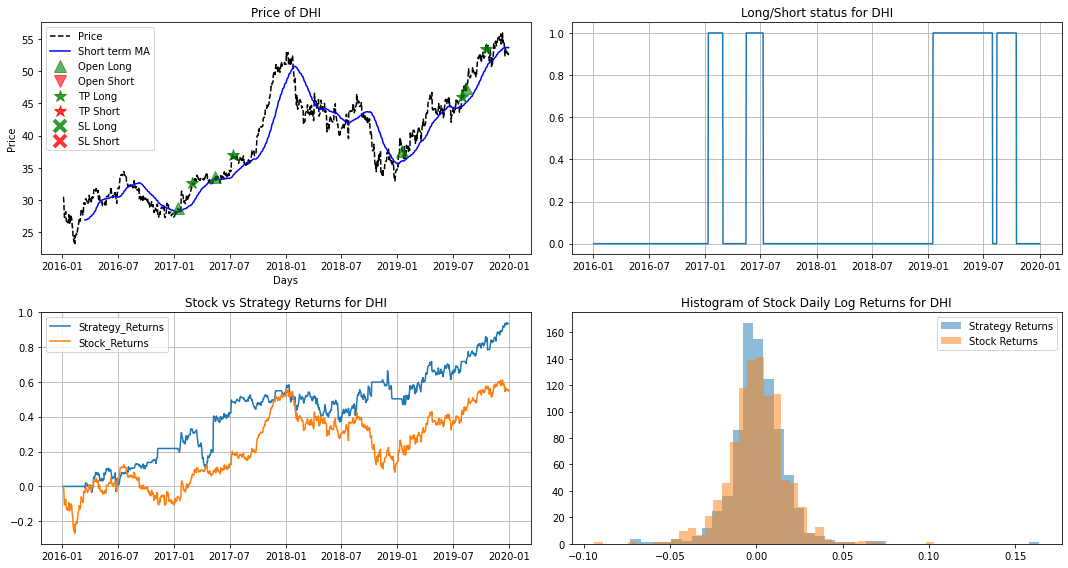

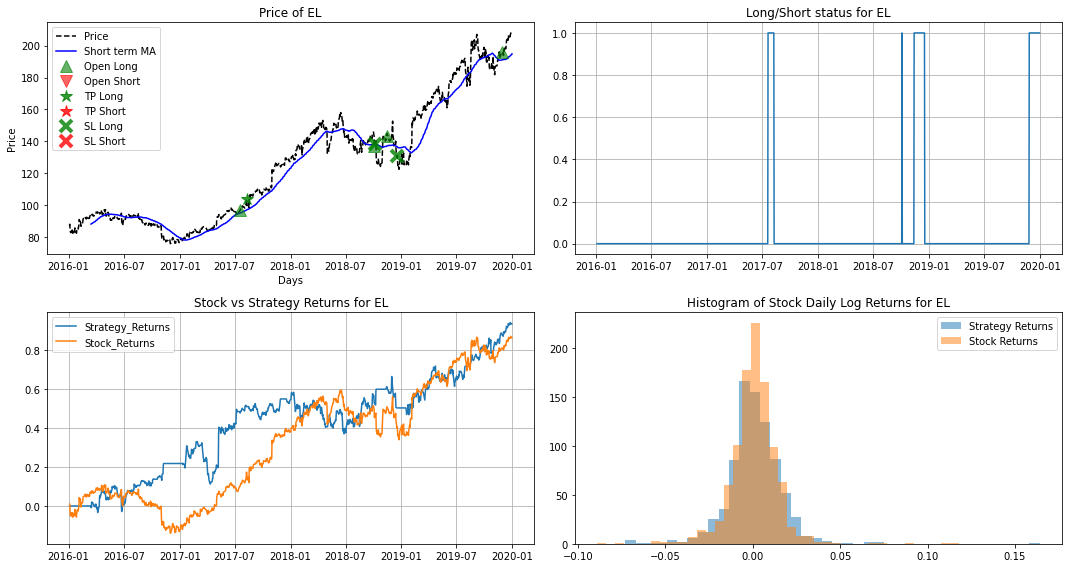

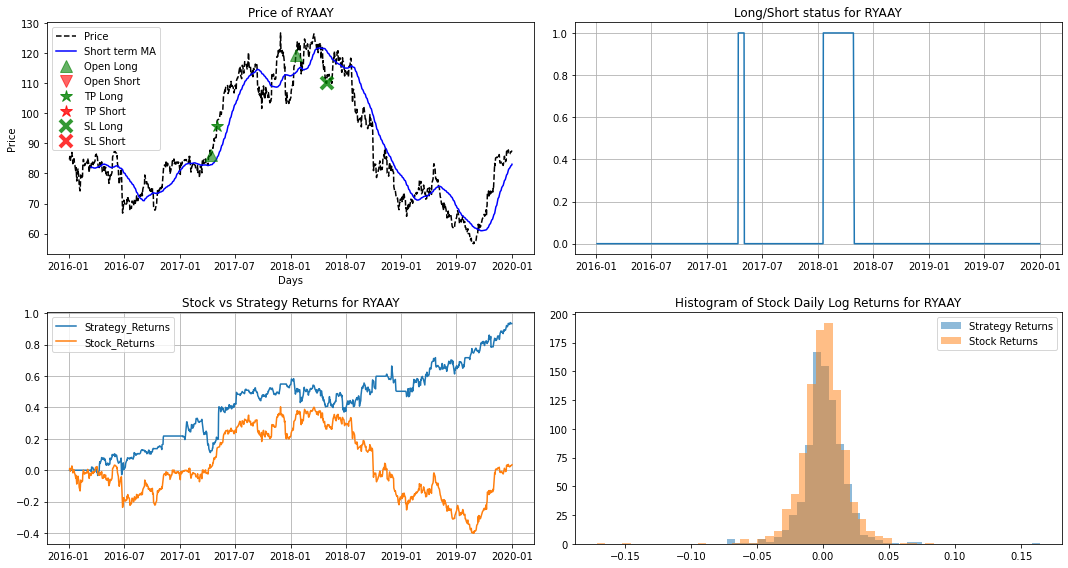

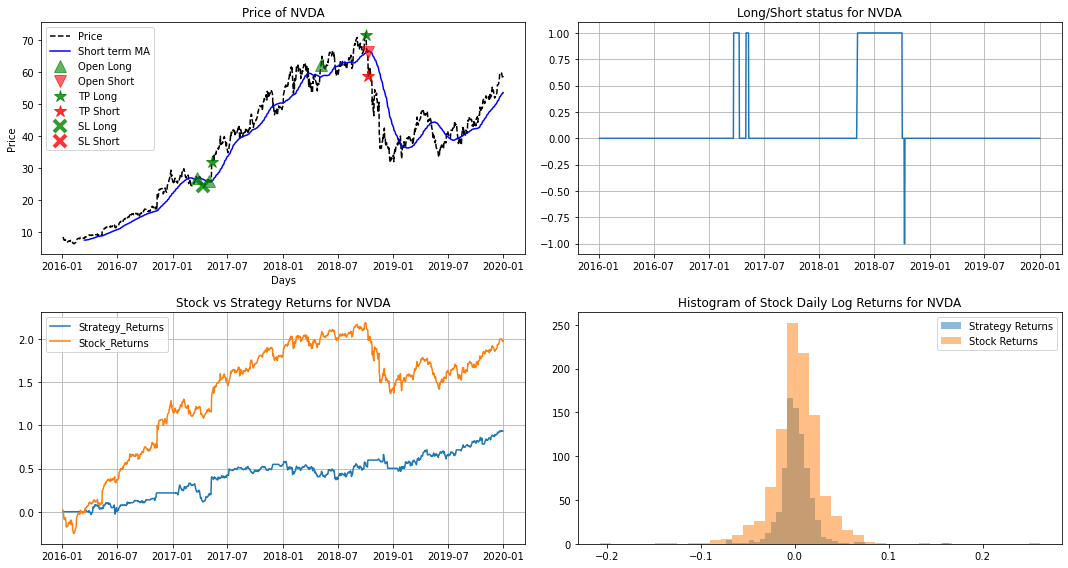

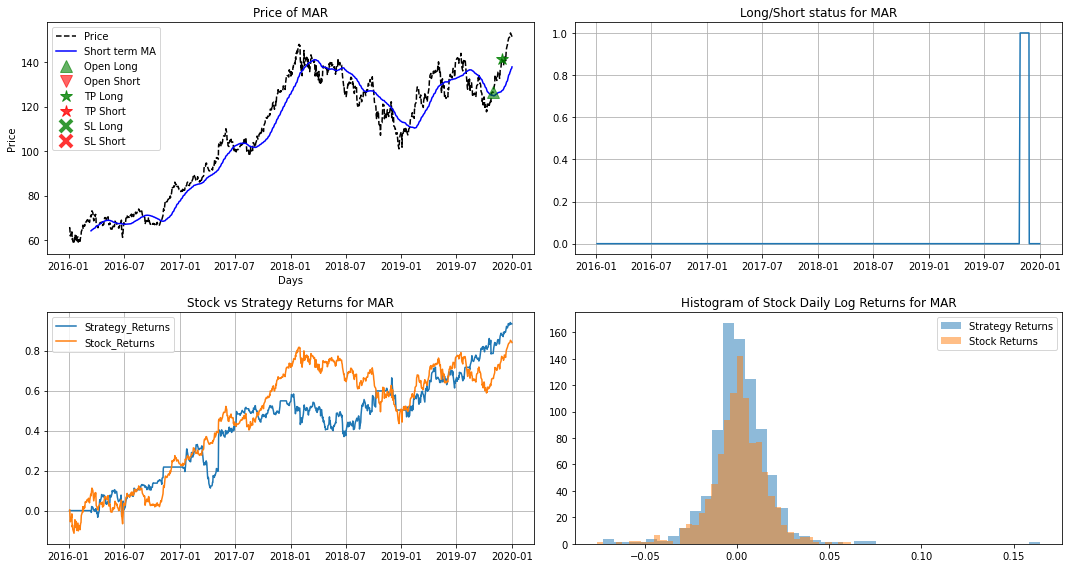

In [22]:
final_model_test_set = SMACD_Strategy(
                # Portfolio configurations
                symbol = ["F", "JPM", "DHI", "EL", "RYAAY", "NVDA", "MAR"],
                benchmark = "^GSPC",
                start = "2016-01-01",
                end = "2019-12-31",
                interval = "1d",
                capital = 500000,
                transaction_cost = 0.0050,
                # Strategy parameters
                buy_on = best_params[9],
                primary_trend_window = best_params[0],
                # Long Parameters
                long_sl_ATR_multiple = best_params[1],
                risk_reward_long = best_params[2],
                close_n_sma_distance_long_multiple = best_params[3],
                long_rsi_limit= best_params[4],
                # Short Parameters
                short_sl_ATR_multiple = best_params[5],
                risk_reward_short = best_params[6],
                close_n_sma_distance_short_multiple= best_params[7],
                short_rsi_limit = best_params[8],
                # Class configurations
                verbose = True,
                stock_data_dict = None,
                benchmark_df = None,
                plot_individual_stocks=True
                )
final_model_test_set_results = final_model_test_set.run_strategy()

### Choosing Best Parameters using Training and Validation Splits (New)

In [10]:
metric = "portfolio_calmar_ratio"
mertic_sorting_direction  = True # True means higher is better, False is lower is better

# Critiria to choose parameters combinations
Since our strategy does not track an index or aim to beat a specific index, We do not use IR or Treynor to judge the best parameters.

Instead to minimise downside risk, we are choosing Calmar Ratio such that we get a strategy with good returns with low drawdowns

1. Validation Calmar Ratio > Train Calmar Ratio (To Prevent Over Fitting)
2. Train & Validation Calmar Ratio > 0

In [14]:
all_returns_df['Params'] = parameters
metric_only_df = all_returns_df.copy()
metric_only_df = metric_only_df[
                            (metric_only_df[f'{metric}_validation'] > metric_only_df[f'{metric}']) &
                            (metric_only_df[f'{metric}_validation'] > 0) & 
                            (metric_only_df[f'{metric}'] > 0) 
                            ]
print(f'After filtering, we are only left with {len(metric_only_df)} parameters combination from the initial 1536')

After filtering, we are only left with 31 parameters combination from the initial 1536


#### Top 10 parameter combinations

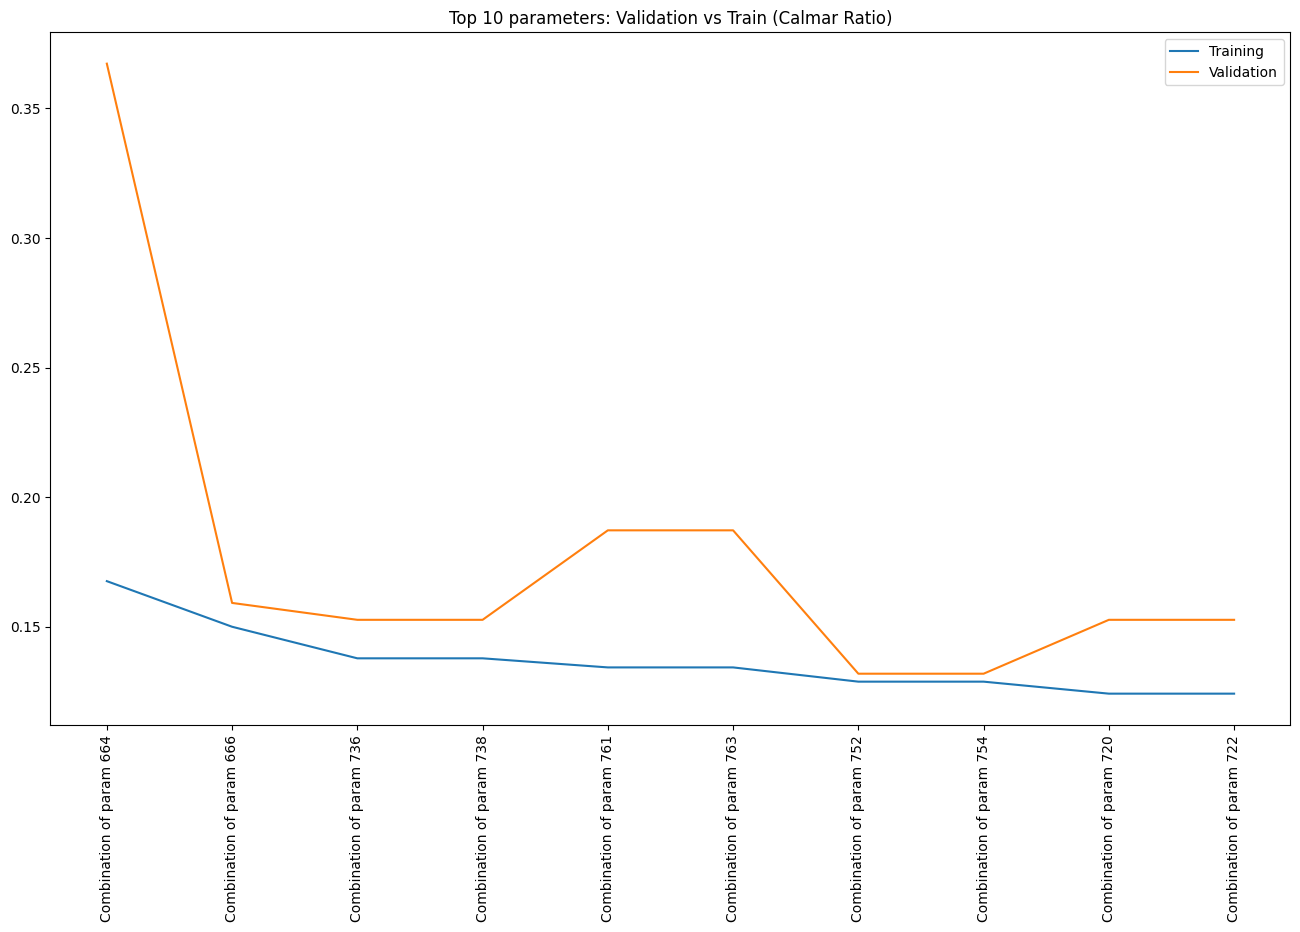

In [30]:
top_ten_params = metric_only_df.sort_values([f'{metric}',f'{metric}_validation'], ascending=[False, False]).head(10)
plt.figure(figsize=(16, 9))
plt.plot(top_ten_params[f'{metric}'], label='Training')
plt.plot(top_ten_params[f'{metric}_validation'], label='Validation')
plt.title('Top 10 parameters: Validation vs Train (Calmar Ratio)')
plt.xticks(rotation=90)
plt.legend()

From the plot above, Combination 664 have the best validation and train calmar ratio. 
However, the difference between the validation and train calmar ratio is too large, and the combination might not be the best due to its uncertainty. 

Hence, we choose parameters combination 666, since its train and validation calmar ratio are quite close.

#### Countplot of the occurence of each parameter in the top 10 choices

In [31]:
all_params_name_list = ["primary_trend_window_params","long_sl_ATR_multiple_params","risk_reward_long_params",
            "close_n_sma_distance_long_multiple_params","long_rsi_limit_params","short_sl_ATR_multiple_params",
           "risk_reward_short_params","close_n_sma_distance_short_multiple_params","short_rsi_limit_params","buy_on"]

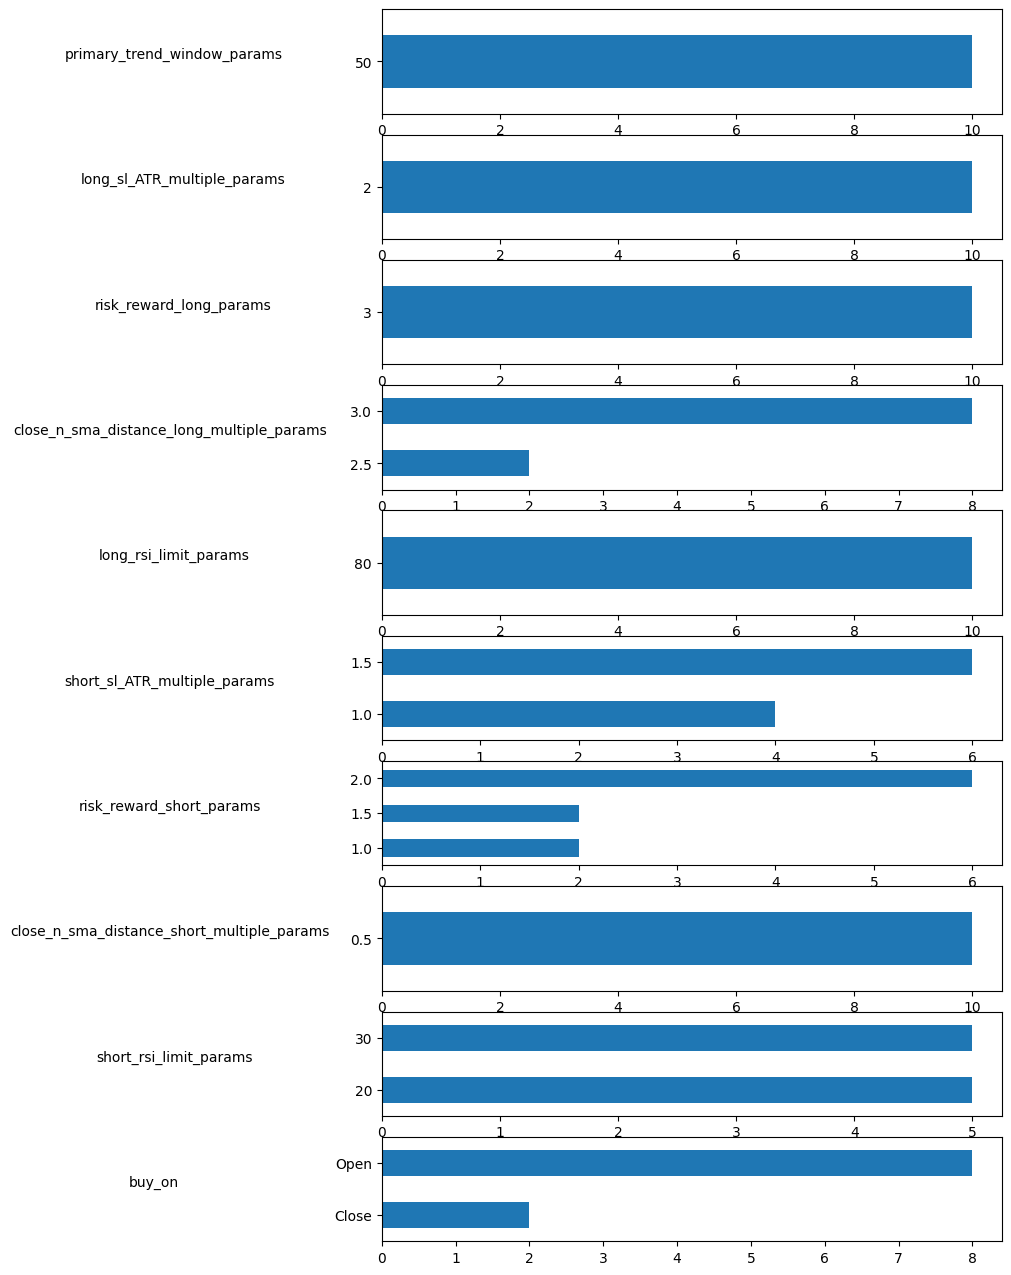

In [33]:
top_ten_params[all_params_name_list] = pd.DataFrame(top_ten_params.Params.tolist(), index= top_ten_params.index)
_,_ = plt.subplots(10,1,figsize=(8,16))
for i in range(1,len(all_params_name_list)+1):
    plt.subplot(10,1, i)
    plt.ylabel("y", rotation=0,labelpad=130)
    top_ten_params.groupby(all_params_name_list[i-1]).count()[metric].plot.barh()

Some parameters occur more frequently in the top 10 params, indicating that there might be a possible correlation of with better returns. For example, for the parameter "primary_trend_window_params", all the top 10 parameters have the value of 50.

#### Final model parameters selection

In [36]:
best_params = top_ten_params.iloc[1]['Params']
for i in range(len(best_params)):
    print(f'{all_params_name_list[i]} = {best_params[i]}')

primary_trend_window_params = 50
long_sl_ATR_multiple_params = 2
risk_reward_long_params = 3
close_n_sma_distance_long_multiple_params = 2.5
long_rsi_limit_params = 80
short_sl_ATR_multiple_params = 1.5
risk_reward_short_params = 2
close_n_sma_distance_short_multiple_params = 0.5
short_rsi_limit_params = 30
buy_on = Open


## Final model results on Training Set

Starting capital: 500000
Final capital: 1322162.74
The total trades taken by the strategy: 74
Number of Take Profits are 18
Number of Stop Losses are 19

-----------Strategy Stats-----------
Normal Portfolio returns: 162.76 %
Log Portfolio returns: 96.61 %
Portfolio Annual Mean returns: 0.18
Portfolio Annual Regular std: 0.24
Portfolio Annual Sharpe Ratio: 0.72
^GSPC Benchmark Annual Mean returns: 0.11
Annual Information Ratio: 0.20
Portfolio Treynor Ratio: 22.19
Portfolio Calmar Ratio: 0.35
Portfolio Sortino Ratio: 1.08
The maximum drawdown: 49.72 %
The maximum drawdown period: 409.00 days

-----------Equal Weighted Port Stats-----------
Normal Portfolio returns: 130.62 %
Log Portfolio returns: 83.56 %
Portfolio Annual Mean returns: 0.15
Portfolio Annual Regular std: 0.21
Portfolio Annual Sharpe Ratio: 0.70
^GSPC Benchmark Annual Mean returns: 0.11
Annual Information Ratio: 0.38
Portfolio Treynor Ratio: 0.12
Portfolio Calmar Ratio: 0.35
Portfolio Sortino Ratio: 0.97
The maximum drawdo

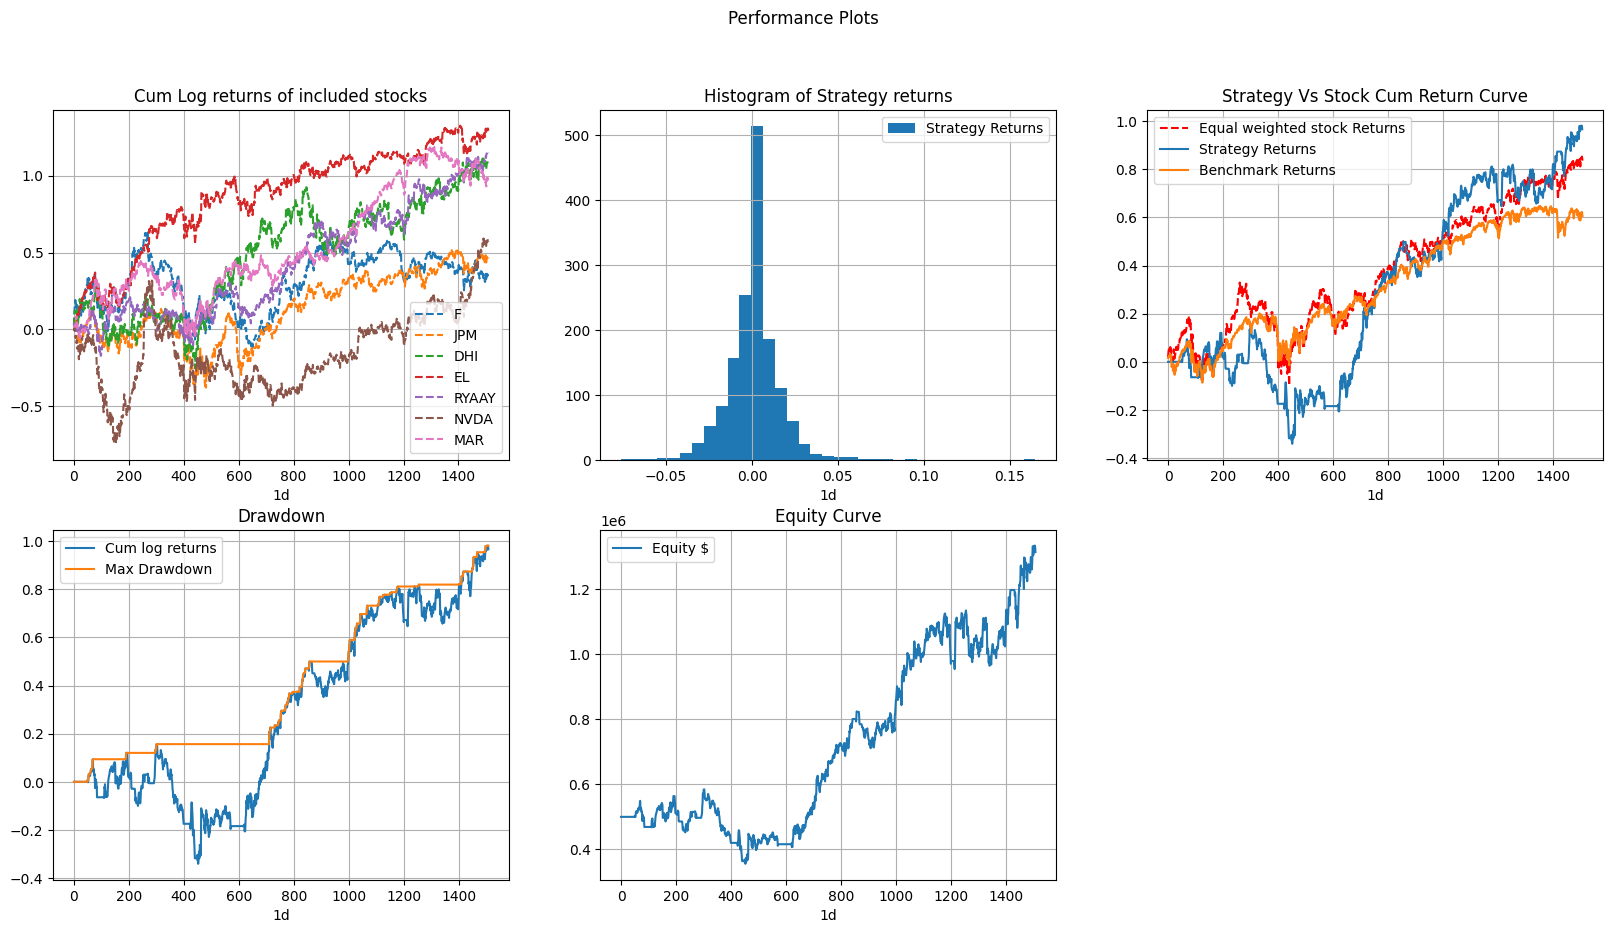

In [37]:
final_model_train_set = SMACD_Strategy(
                # Portfolio configurations
                symbol =  ["F", "JPM", "DHI", "EL", "RYAAY", "NVDA", "MAR"],
                benchmark = "^GSPC",
                start = "2010-01-01",
                end = "2015-12-31",
                interval = "1d",
                capital = 500000,
                transaction_cost = 0.0050,
                # Strategy parameters
                buy_on = best_params[9],
                primary_trend_window = best_params[0],
                # Long Parameters
                long_sl_ATR_multiple = best_params[1],
                risk_reward_long = best_params[2],
                close_n_sma_distance_long_multiple = best_params[3],
                long_rsi_limit= best_params[4],
                # Short Parameters
                short_sl_ATR_multiple = best_params[5],
                risk_reward_short = best_params[6],
                close_n_sma_distance_short_multiple= best_params[7],
                short_rsi_limit = best_params[8],
                # Class configurations
                verbose = False,
                stock_data_dict = None,
                benchmark_df = None,
                plot_individual_stocks=False
                )

final_train_set_results = final_model_train_set.run_strategy()

## Final model results on Test Set without Trading Fees

Starting capital: 500000
Final capital: 1568934.13
The total trades taken by the strategy: 44
Number of Take Profits are 14
Number of Stop Losses are 8

-----------Strategy Stats-----------
Normal Portfolio returns: 215.07 %
Log Portfolio returns: 114.76 %
Portfolio Annual Mean returns: 0.33
Portfolio Annual Regular std: 0.24
Portfolio Annual Sharpe Ratio: 1.40
^GSPC Benchmark Annual Mean returns: 0.12
Annual Information Ratio: 0.65
Portfolio Treynor Ratio: -76.97
Portfolio Calmar Ratio: 1.73
Portfolio Sortino Ratio: 1.88
The maximum drawdown: 19.29 %
The maximum drawdown period: 180.00 days

-----------Equal Weighted Port Stats-----------
Normal Portfolio returns: 89.56 %
Log Portfolio returns: 63.95 %
Portfolio Annual Mean returns: 0.17
Portfolio Annual Regular std: 0.17
Portfolio Annual Sharpe Ratio: 1.01
^GSPC Benchmark Annual Mean returns: 0.12
Annual Information Ratio: 0.47
Portfolio Treynor Ratio: 0.16
Portfolio Calmar Ratio: 0.43
Portfolio Sortino Ratio: 1.33
The maximum drawdo

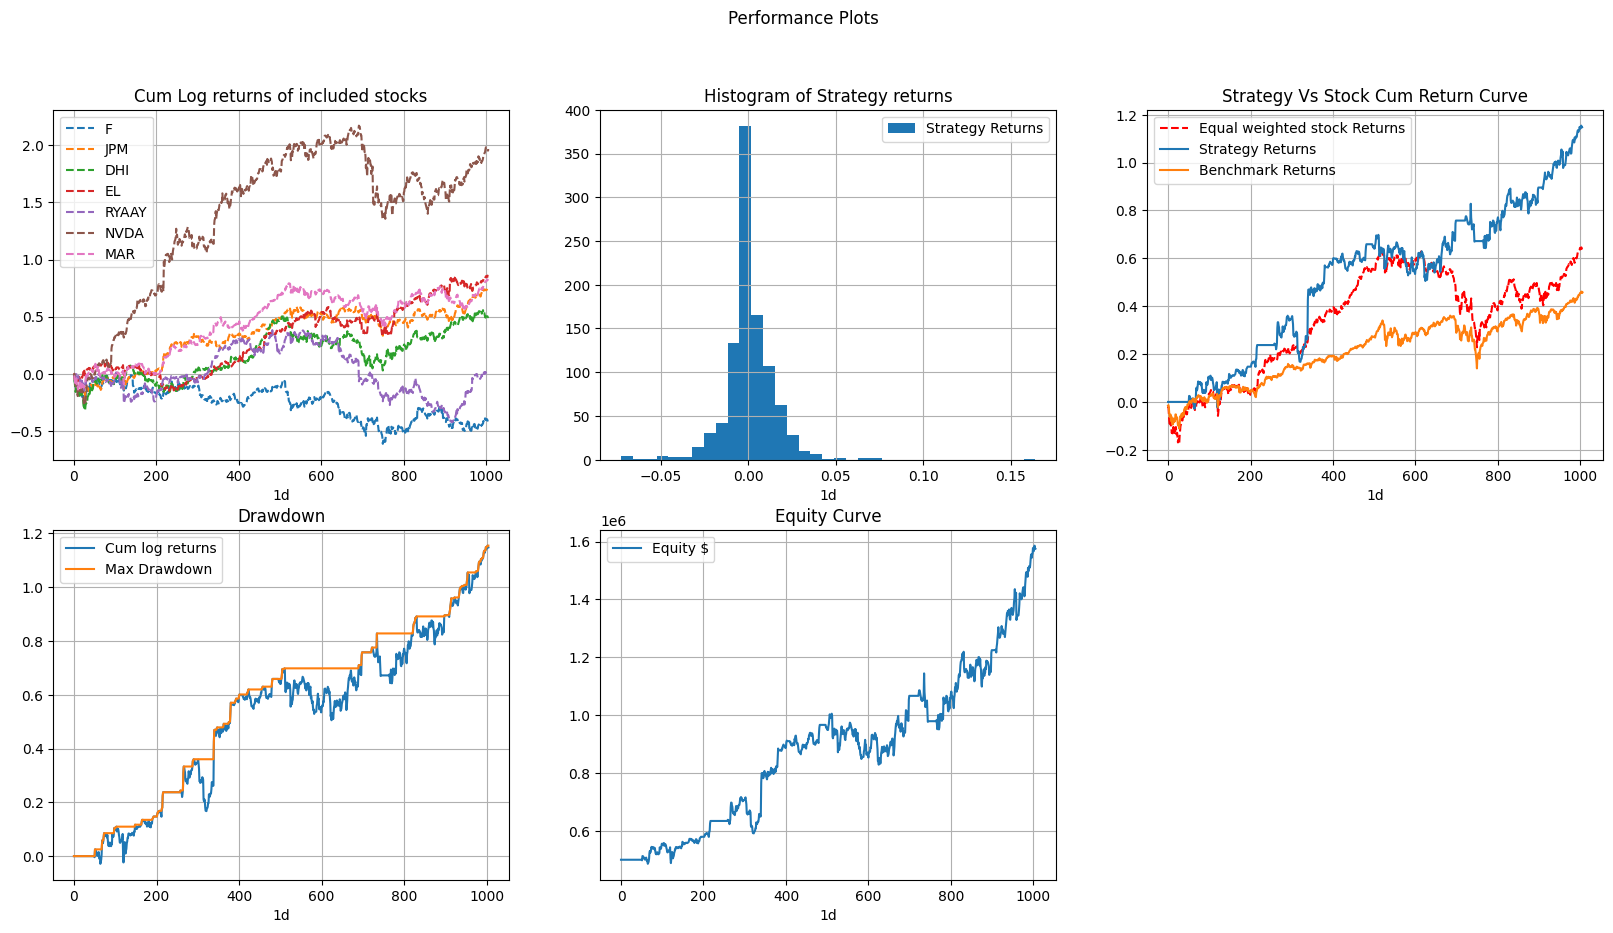

In [38]:
final_model_test_set = SMACD_Strategy(
                # Portfolio configurations
                symbol = ["F", "JPM", "DHI", "EL", "RYAAY", "NVDA", "MAR"],
                benchmark = "^GSPC",
                start = "2016-01-01",
                end = "2019-12-31",
                interval = "1d",
                capital = 500000,
                transaction_cost = 0.00,
                # Strategy parameters
                buy_on = best_params[9],
                primary_trend_window = best_params[0],
                # Long Parameters
                long_sl_ATR_multiple = best_params[1],
                risk_reward_long = best_params[2],
                close_n_sma_distance_long_multiple = best_params[3],
                long_rsi_limit= best_params[4],
                # Short Parameters
                short_sl_ATR_multiple = best_params[5],
                risk_reward_short = best_params[6],
                close_n_sma_distance_short_multiple= best_params[7],
                short_rsi_limit = best_params[8],
                # Class configurations
                verbose = False,
                stock_data_dict = None,
                benchmark_df = None,
                plot_individual_stocks=False
                )
final_model_test_set_results = final_model_test_set.run_strategy()

## Final model results on Test Set With Trading Fees


---------Open Long----------
Bought 8435 shares of JPM at 59.0 per share worth 497496.3 $
Date :2016-03-16 | Realised Balance: 16.2
Sold 8435 shares of JPM at 68.3 per share worth 576447.9 $
Date :2016-10-10 | Realised Balance: 573581.9
---------Close Long at TP----------

---------Open Long----------
Bought 8416 shares of JPM at 67.8 per share worth 570688.9 $
Date :2016-10-21 | Realised Balance: 39.5
Sold 8416 shares of JPM at 74.2 per share worth 624635.5 $
Date :2016-11-10 | Realised Balance: 621551.8
---------Close Long at TP----------

---------Open Long----------
Bought 21692 shares of DHI at 28.5 per share worth 618438.9 $
Date :2017-01-12 | Realised Balance: 20.7
Sold 21692 shares of DHI at 32.2 per share worth 699133.2 $
Date :2017-03-01 | Realised Balance: 695658.2
---------Close Long at TP----------

---------Open Long----------
Bought 54418 shares of F at 12.7 per share worth 692197.0 $
Date :2017-03-02 | Realised Balance: 0.2
Sold 54418 shares of F at 11.7 per share wort

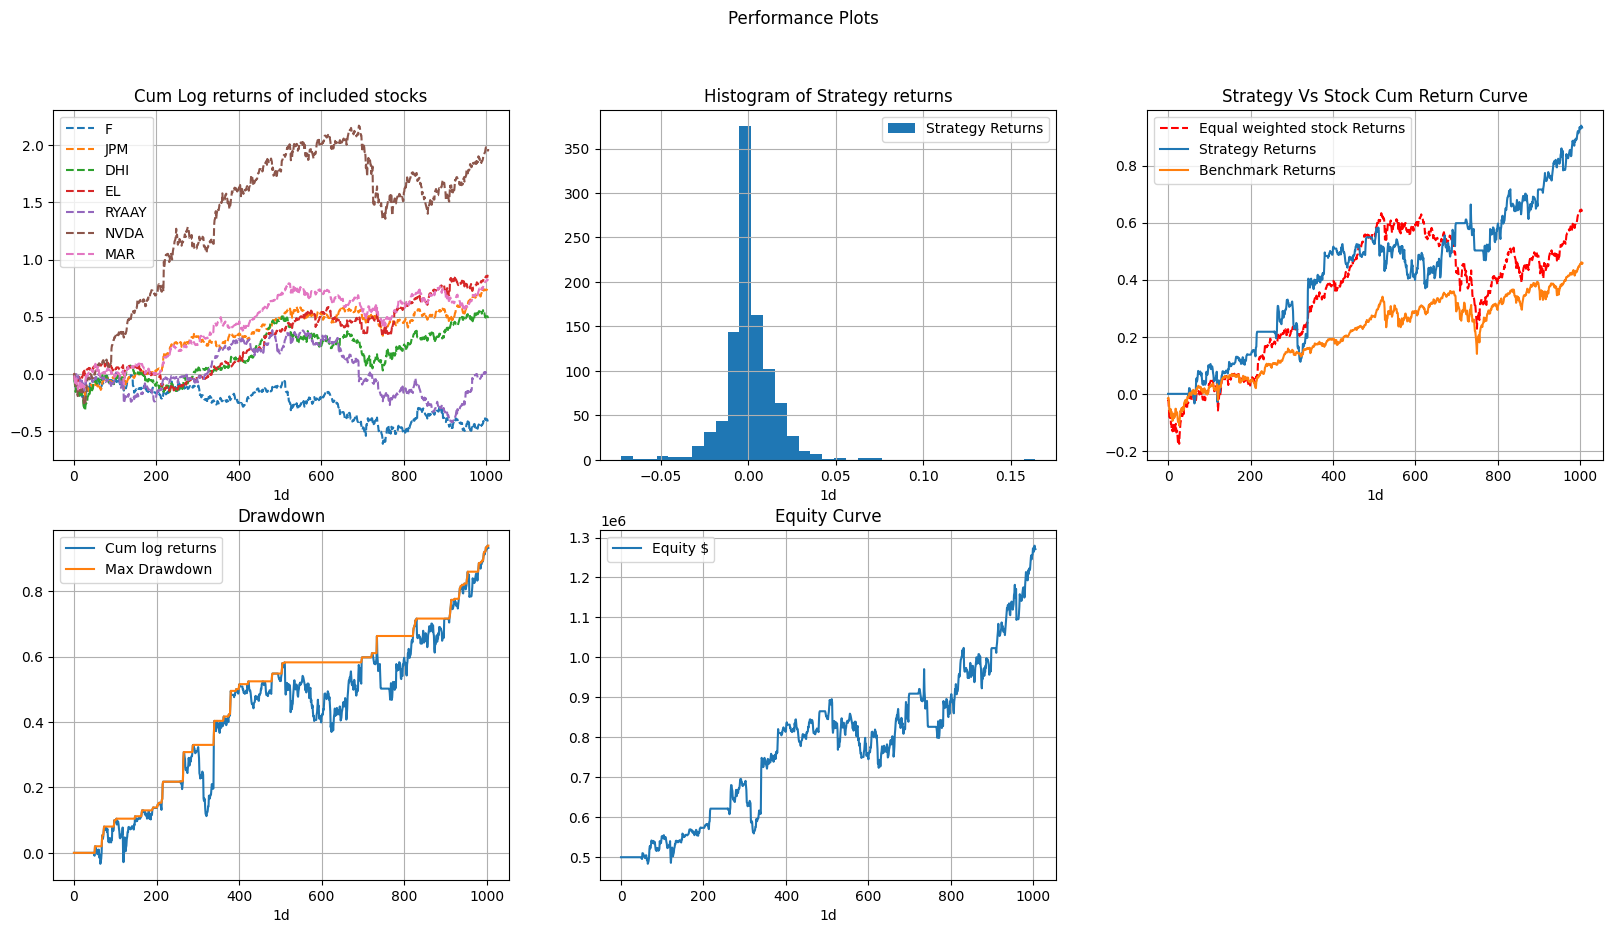

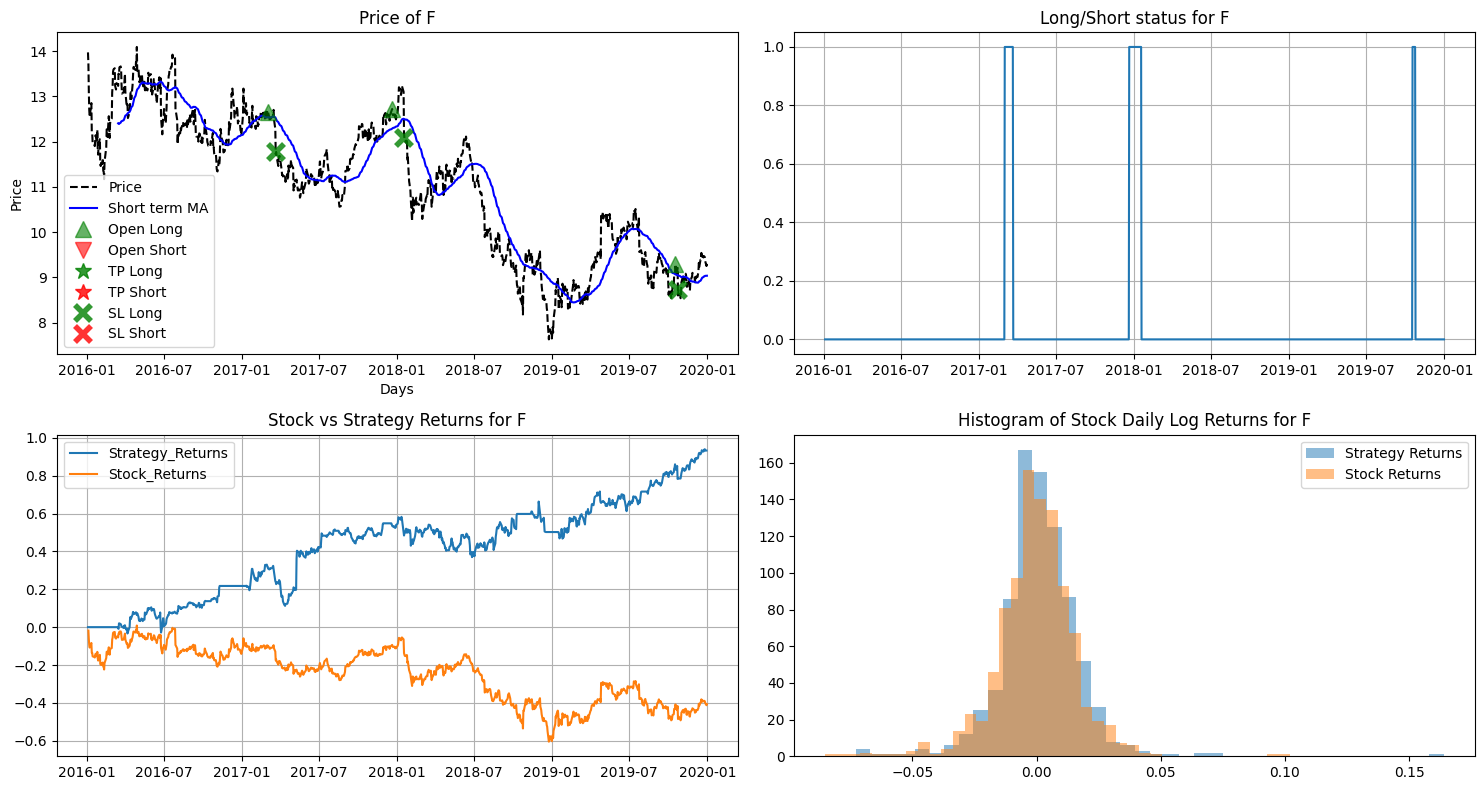

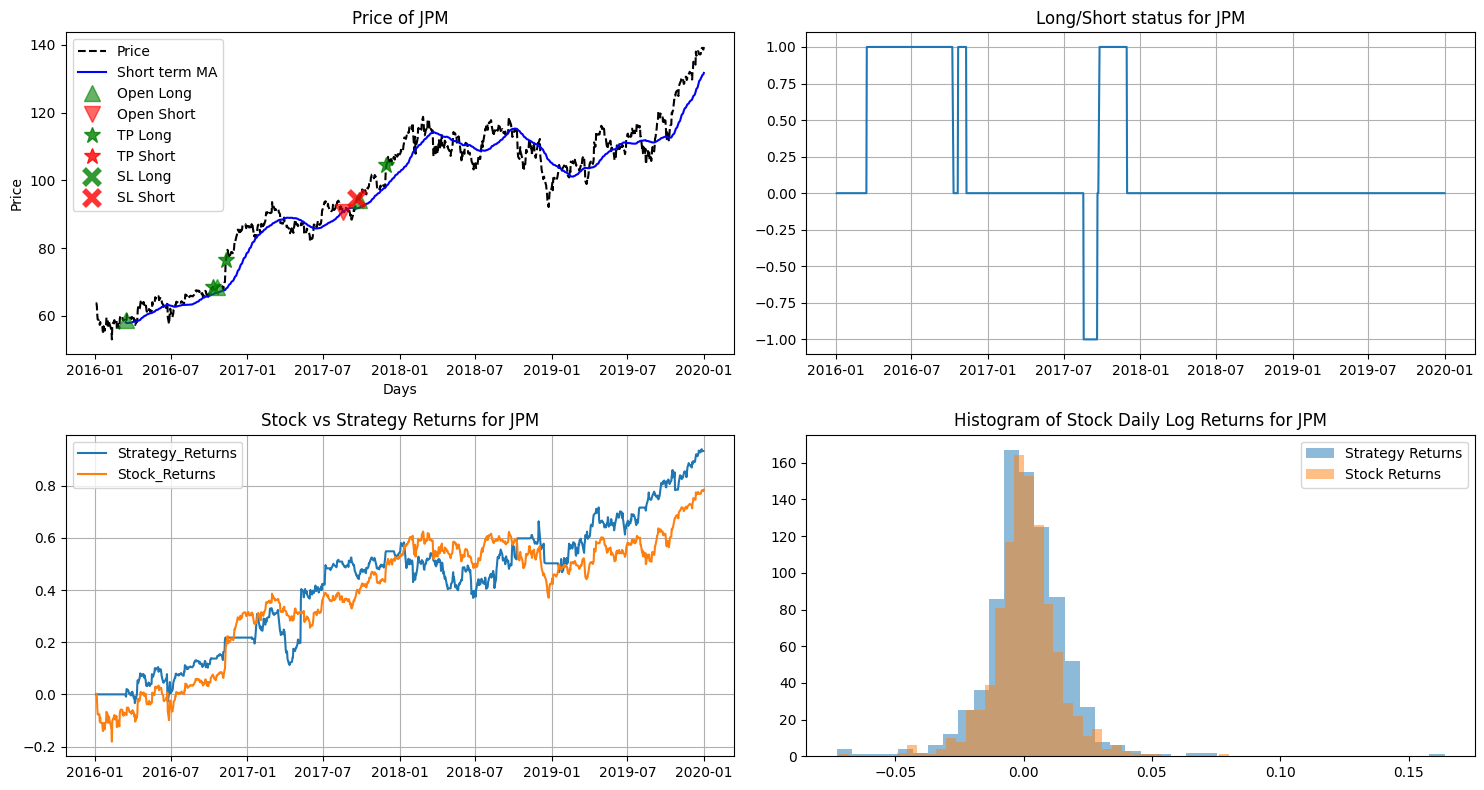

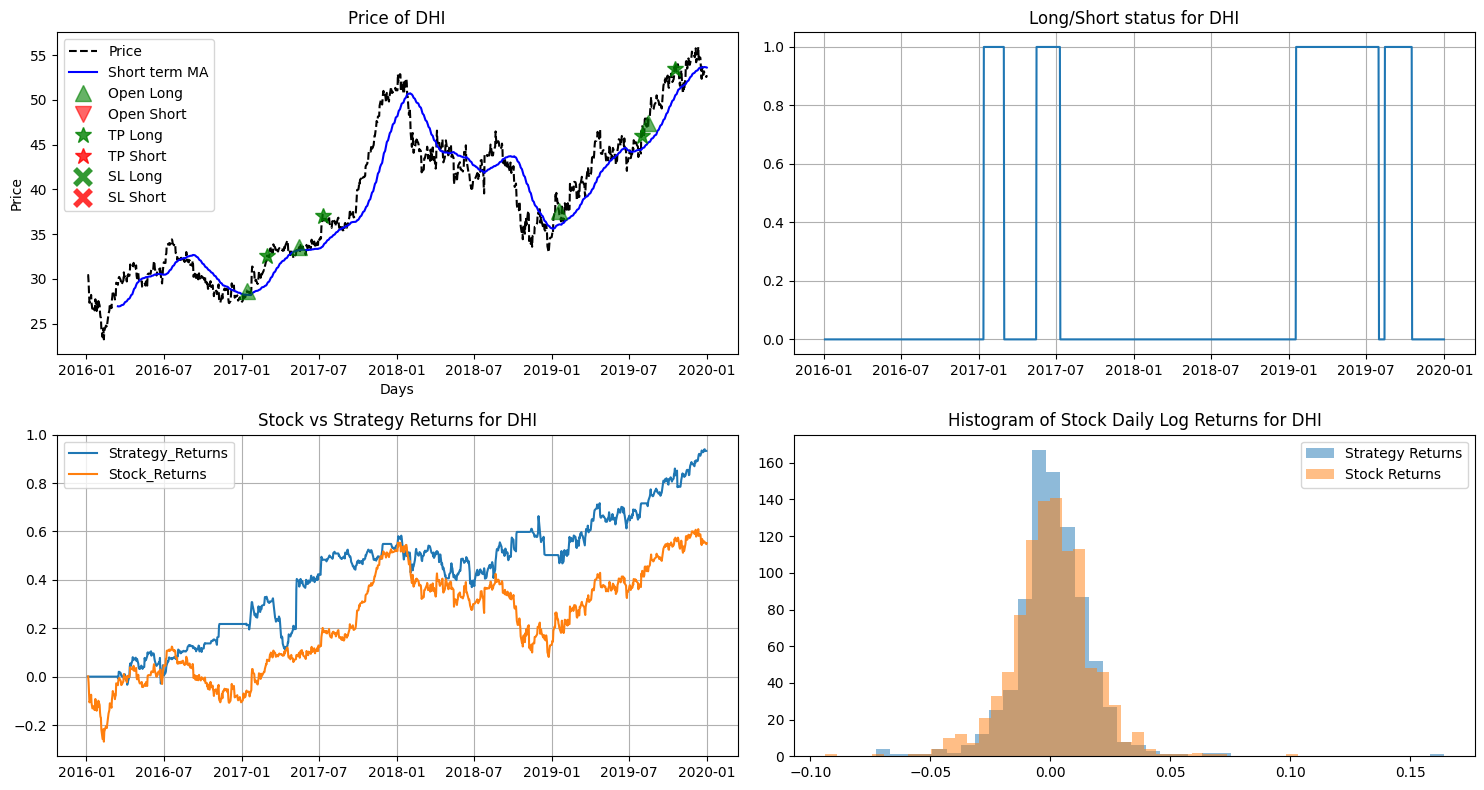

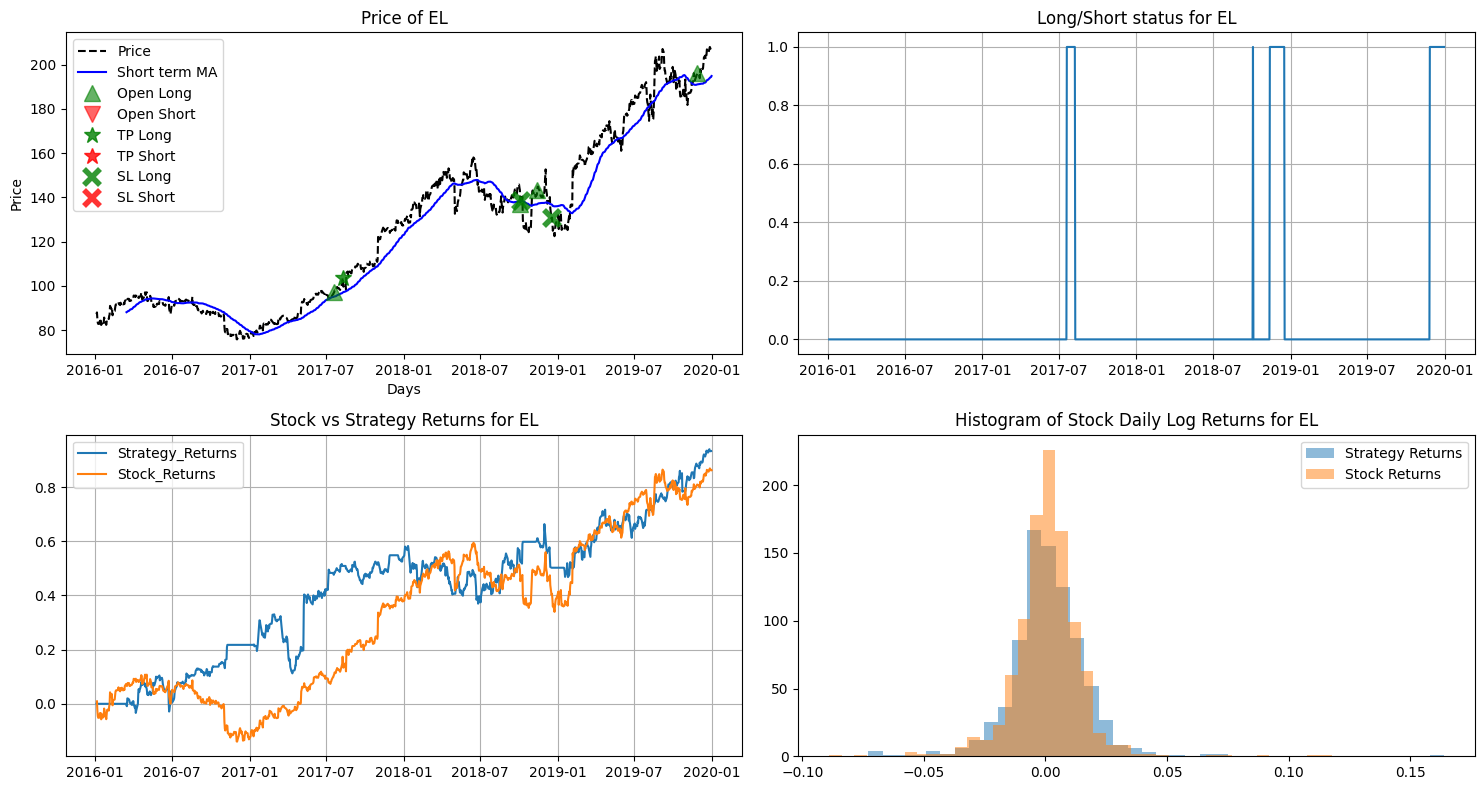

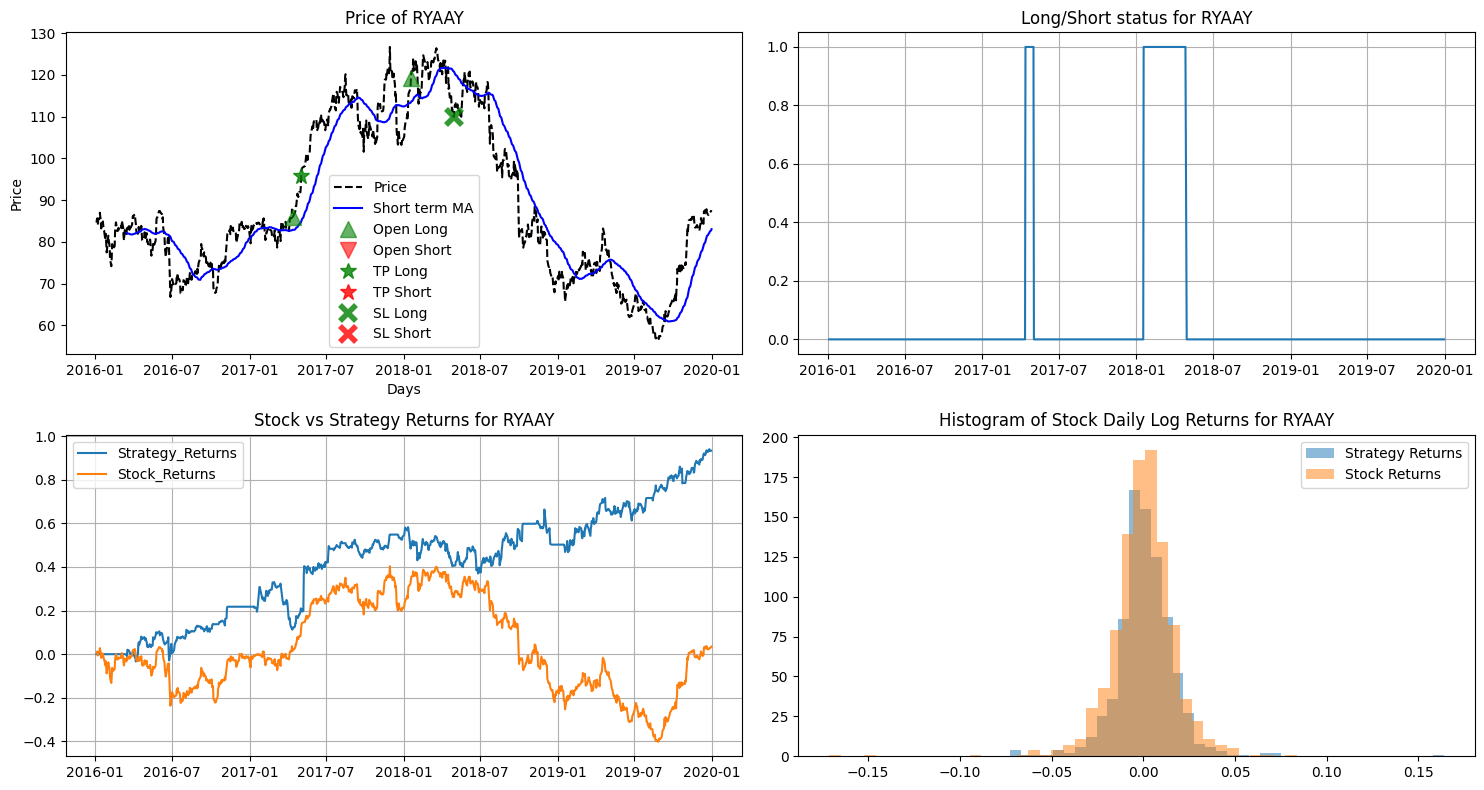

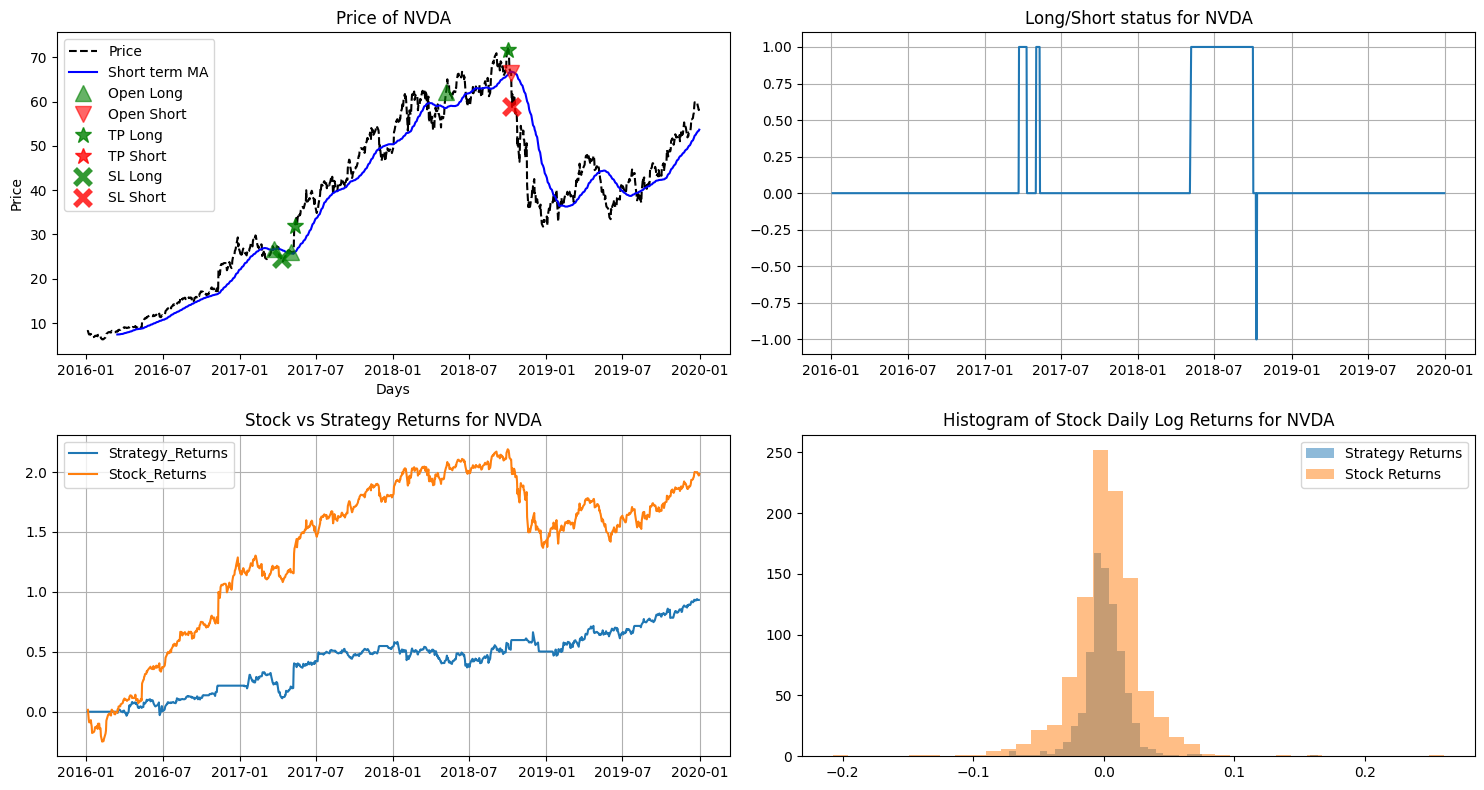

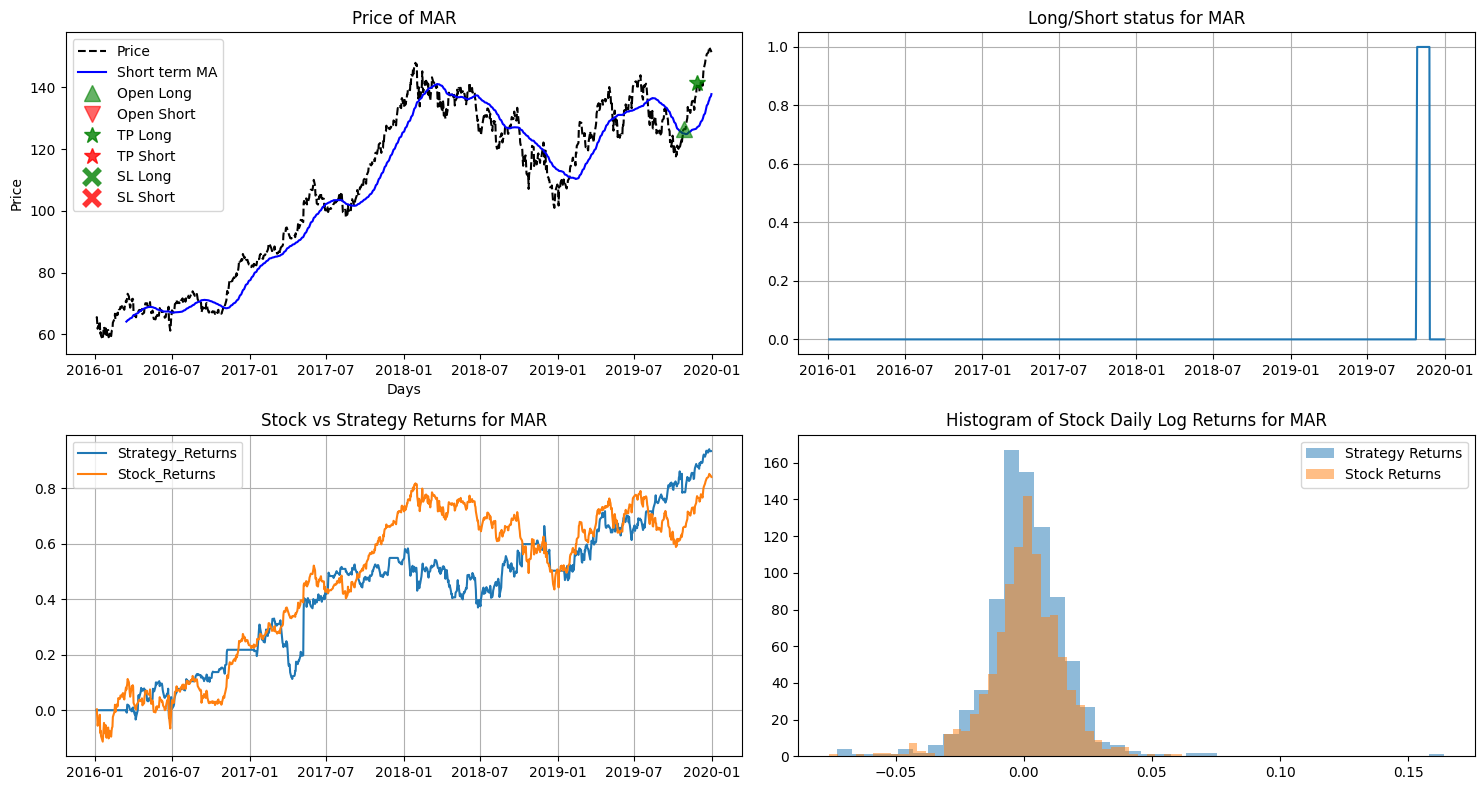

In [40]:
final_model_test_set = SMACD_Strategy(
                # Portfolio configurations
                symbol = ["F", "JPM", "DHI", "EL", "RYAAY", "NVDA", "MAR"],
                benchmark = "^GSPC",
                start = "2016-01-01",
                end = "2019-12-31",
                interval = "1d",
                capital = 500000,
                transaction_cost = 0.0050,
                # Strategy parameters
                buy_on = best_params[9],
                primary_trend_window = best_params[0],
                # Long Parameters
                long_sl_ATR_multiple = best_params[1],
                risk_reward_long = best_params[2],
                close_n_sma_distance_long_multiple = best_params[3],
                long_rsi_limit= best_params[4],
                # Short Parameters
                short_sl_ATR_multiple = best_params[5],
                risk_reward_short = best_params[6],
                close_n_sma_distance_short_multiple= best_params[7],
                short_rsi_limit = best_params[8],
                # Class configurations
                verbose = True,
                stock_data_dict = None,
                benchmark_df = None,
                plot_individual_stocks=True
                )
final_model_test_set_results = final_model_test_set.run_strategy()

# Summary

|                                   | Training Set (2010-01-01 to 2015-12-31) | Test Set (2016-01-01 to 2019-12-31) |
|----------------------------------:|----------------------------------------:|------------------------------------:|
|                     Final Capital |                              1322162.74 |                          1265866.18 |
|          Normal Portfolio returns |                                  162.76 |                              154.21 |
|               Annual Mean Returns |                                    0.18 |                                0.26 |
| Annual Regular Standard Deviation |                                    0.24 |                                0.24 |
|               Annual Sharpe Ratio |                                    0.72 |                                1.11 |
|                      Calmar Ratio |                                    0.35 |                                1.21 |